# Example Sheet 2: James Hughes

## Supervisor Feedback
Homework 2

Question 1
a)  Very good graphs and explanation!! Also, good choice ot choose k =5 against similarly performing higher values! For visualisation, you can experiment with dimensionality reduction and visualising results in 2 or 3 dimensions.


b) Very good!! You can also experiment with different numbers or "intensities" of outliers and show results in a plot for a chosen method.

Question2

a) very good! You can also try different optimisation methods.

b and c) very good! You can also summarise accuracy or 1-score for different data sizes by plotting one of the metrics for the optimal C parameter in each case against fraction of data used to train. 

## Class Notes/Discussion

In practice, for compelx problems there are faster ways of optimisng the hyperparameters than exhaustive grid search:
- Random grid search in some range
- Gradient based methods (e.g. for optimising k in KNN)
- Bayesian Methods

Generative vs. Discriminative
- Generative method: break the classification problem into first learning the joint distribution for X and $C_k$, and then apply Bayes Theorem to get the posterior P(Ck|X) from P(X|Ck). Crucially we assume the form of the data.
- Discriminative method: learn the posterior probability directly; we don't assume an underlying distribution for X.

Parametric vs. Non-parametric model:
- Non-parametric models have an unconstrained form, e.g. KNN or Decision Trees. For instance, KNN has the hyperparameter k, but this isn't a 'parameter'.

Best to actually output best cross-validation score and optimal hyperparameters explicitly: best C was 7.2, best score was accuracy 0.98 for instance.

The reason why SVMs with kernels are so effective is because we are implictly mapping the data to a higher dimensional space, $\phi : X -> H$ and then $K(x,x') = <\phi(x),\phi(x')>_H$ but we don't need the analytical form of the higher dimensional feature map $\phi$, we only need the Kernel $K$, and in fact only the matrix of all values $[K(x_i,x_j)]$.

Note in fact that the polynomial kernel maps to a higher dimensional space, while the rbf kernel maps to an infinite dimensional space!

Discriminant Analysis: both models assume that $P(X|C_k)$ is normally distributed. LDA takes the assumption of homoscedasticity; identical covariance matrices (thus always resulting in a linear boundary). QDA relaxes this assumption so we can get a non-linear boundary. The essential term that depends on X to determine the posterior $P(X|C_k)$ is the Mahalonobis distance from $\mu_k$.

Robustness is the ability to generalise to new unseen data.

Use classifciation_report to produce precision, recall, f1-score and accuracy.

Remember that CV is used to compare two different types of model, or to compare the same model with different hyperparameters. If you train, say, linear regression and it performs best based on CV, then to get the final model you fit to the whole data - you already know the model is good.

e^x / 1+ e^x = p

1/ 1+e^-x = p

1/p = 1+e^-x

ln(p/(1-p)) = x

We use sigmoid function because in the binary class model

$$ P(C_1|X) = \frac{P(X|C_1)P(C_1)}{P(X|C_1)P(C_1)+P(X|C_2)P(C_2)} $$

We can rewrite

$$ P(C_1|X) = \frac{1}{1+e^{-a}} = \sigma(a) $$

where

$$ a = \log (P(X|C_1)/P(X|C_2)) + \log (P(C_1)/P(C_2)) $$

i.e. loglikelihood ratio plus (Bayes factor??)

## Pre-Amble

In [1]:
from itertools import combinations
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

plt.style.use("/home/jhughes2712/projects/coursework/mphildis-coursework/mphil.mplstyle")

In [2]:
def plot_contours(ax, clf, X, x_idx, y_idx, h=.02, **params):
    x_min, x_max = X[:, x_idx].min() - 1, X[:, x_idx].max() + 1
    y_min, y_max = X[:, y_idx].min() - 1, X[:, y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_predict = np.tile(np.mean(X, axis=0), (xx.shape[0]*xx.shape[1],1))
    X_predict[:, x_idx] = xx.ravel()
    X_predict[:, y_idx] = yy.ravel()
    Z = clf.predict(X_predict)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_boundary(ax, clf, X, y, classes, x_idx, y_idx, h=.02, colourmap=plt.cm.viridis):
    x_min, x_max = X[:, x_idx].min() - 1, X[:, x_idx].max() + 1
    y_min, y_max = X[:, y_idx].min() - 1, X[:, y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_predict = np.tile(np.mean(X, axis=0), (xx.shape[0]*xx.shape[1],1))
    X_predict[:, x_idx] = xx.ravel()
    X_predict[:, y_idx] = yy.ravel()
    Z = clf.predict(X_predict)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=colourmap, alpha=0.8)
    scatter = ax.scatter(X[:,x_idx], X[:,y_idx], c=y, cmap=colourmap, s=20, edgecolors='k')
    handles, labels = scatter.legend_elements()
    legend1 = ax.legend(handles, classes, title="Classes")
    ax.add_artist(legend1)
    return ax

## Question 1: Original Dataset

We begin by preprocessing the data; we first output some descriptive statistics of the four continuous predictors and the categorical target. Since the continuous variables all have different scales we standardise them all (ensuring to fit the scaler on the training data), but not before removing the two rows containing missing values. The target classes are fairly balanced.

In [4]:
penguins_df = sns.load_dataset("penguins").drop(columns=["island", "sex"])
display(penguins_df.head(5))
display(penguins_df.describe(include=["float", "int"]))
display(penguins_df.describe(include=["object"]))

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,NaN,NaN,NaN,NaN
4,Adelie,36.7,19.3,193.0,3450.0


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


,species
count,344
unique,3
top,Adelie
freq,152


In [5]:
null_idx = penguins_df.isnull().any(axis=1)
print("Number of null rows with any null values:", null_idx.sum())

Number of null rows with any null values: 2


In [6]:
penguins_df = penguins_df[~null_idx].reset_index().drop(columns=["index"])
penguins_df.head(5)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,36.7,19.3,193.0,3450.0
4,Adelie,39.3,20.6,190.0,3650.0


In [7]:
X = np.array(penguins_df.drop(columns=["species"]))
label_ec = LabelEncoder()
y = label_ec.fit_transform(penguins_df["species"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

For each of the classifers, we fit using a 5-fold cross validation, and optimising hyperparameters where relevant. We then get a rough idea of the behaviour of the optimised classifier by plotting the decision boundary on the pairs of predictors, when all other predictors are held at their mean values. We output any of the optimised parameters and finally the confusion matrix in predicting the test target values.

### Logistic Regression

In [8]:
lr_clf = LogisticRegression()
lr_cv = GridSearchCV(lr_clf, param_grid={}, cv=5)
lr_cv.fit(X_train, y_train)
lr_results = pd.DataFrame(lr_cv.cv_results_, dtype="float64")
lr_results

/tmp/ipykernel_14573/631065594.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  lr_results = pd.DataFrame(lr_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00951,0.007407,0.001926,0.001658,{},1.0,0.981818,0.981818,0.981481,0.981481,0.98532,0.007342,1.0


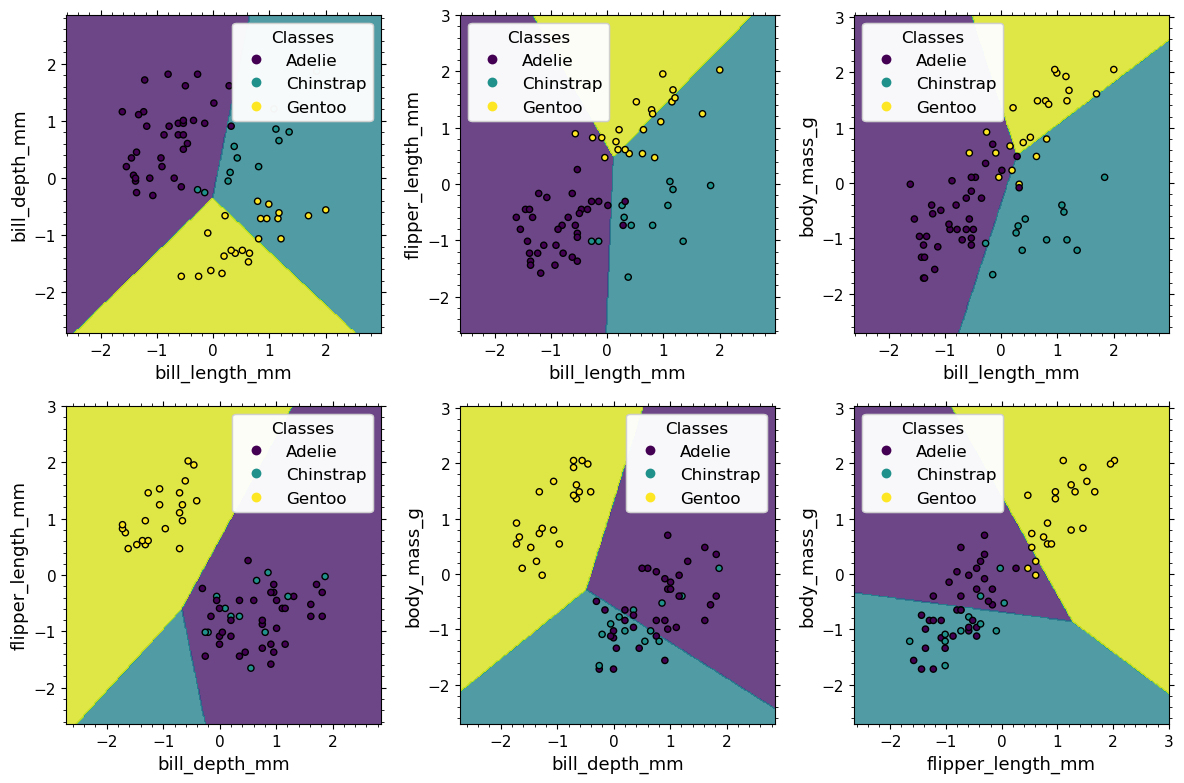

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], lr_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

In [12]:
pd.DataFrame(np.hstack([lr_cv.best_estimator_.intercept_.reshape(-1,1), lr_cv.best_estimator_.coef_]),
    columns = ["intercept"]+["coef_"+feat for feat in ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]],
    index = ["Adelie", "Chinstrap", "Gentoo"]
)

,intercept,coef_bill_length_mm,coef_bill_depth_mm,coef_flipper_length_mm,coef_body_mass_g
Adelie,0.386888,-2.561076,1.335230,-0.481145,0.205356
Chinstrap,-0.095043,2.224874,0.346736,-0.683202,-1.331144
Gentoo,-0.291844,0.336203,-1.681966,1.164346,1.125788


The logistic regression classifier uses a one-vs-many approach, with three logistic models being implemented, one for each class. The intercepts indicate a bias in the overall model; when all scaled parameters are at zero (their training set mean) the model predicts the Adelie class. This reflects Adelie's status as the modal target class. The coefficients give us heuristic understanding of the model, for instance, all other predictors being constant, a very small bill length penguin is predicted as an Adelie species, while a very large bill length penguin is predicted to be a Chinstrap penguin. This can be verified from the first 3 decision boundary plots - the purple area is always on the left, the blue on the right.

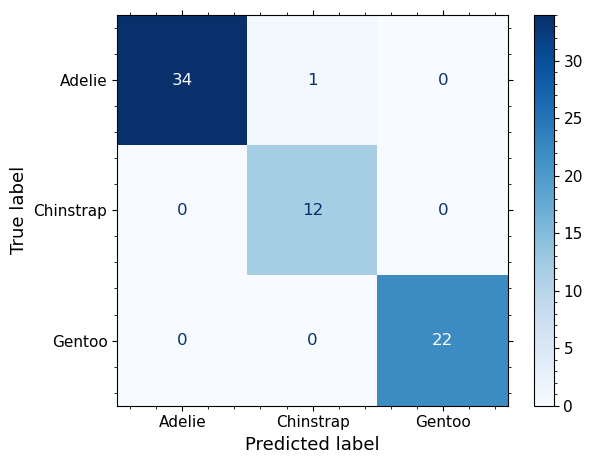

In [13]:
ConfusionMatrixDisplay.from_estimator(lr_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Nearest Neighbours

In [14]:
knn_clf = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_clf, param_grid={"n_neighbors":[2, 3, 4, 5, 7, 10, 15, 20, 30, 40]}, cv=5)
knn_cv.fit(X_train, y_train)
knn_results = pd.DataFrame(knn_cv.cv_results_, dtype="float64")
knn_results

/tmp/ipykernel_14573/1387840006.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  knn_results = pd.DataFrame(knn_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001776,0.001189,0.010488,0.005748,2.0,{'n_neighbors': 2},0.981818,0.981818,0.963636,0.962963,0.962963,0.970640,0.009130,10.0
1,0.001196,0.000647,0.008345,0.002580,3.0,{'n_neighbors': 3},1.000000,0.981818,0.981818,0.981481,0.962963,0.981616,0.011713,8.0
2,0.001978,0.001221,0.007661,0.002518,4.0,{'n_neighbors': 4},1.000000,0.981818,0.963636,0.981481,0.981481,0.981684,0.011500,5.0
3,0.001807,0.001171,0.008972,0.001614,5.0,{'n_neighbors': 5},1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,1.0
4,0.001305,0.000660,0.009031,0.002207,7.0,{'n_neighbors': 7},1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,1.0
5,0.002143,0.001667,0.008074,0.001409,10.0,{'n_neighbors': 10},1.000000,0.981818,0.963636,0.981481,0.981481,0.981684,0.011500,5.0
6,0.000933,0.000208,0.006955,0.002062,15.0,{'n_neighbors': 15},1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,1.0
7,0.001008,0.000551,0.007668,0.002271,20.0,{'n_neighbors': 20},1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,1.0
8,0.000871,0.000135,0.008574,0.001825,30.0,{'n_neighbors': 30},1.000000,0.981818,0.963636,0.981481,0.981481,0.981684,0.011500,5.0
9,0.002016,0.001676,0.008094,0.002021,40.0,{'n_neighbors': 40},0.981818,0.981818,0.981818,0.944444,0.981481,0.974276,0.014916,9.0


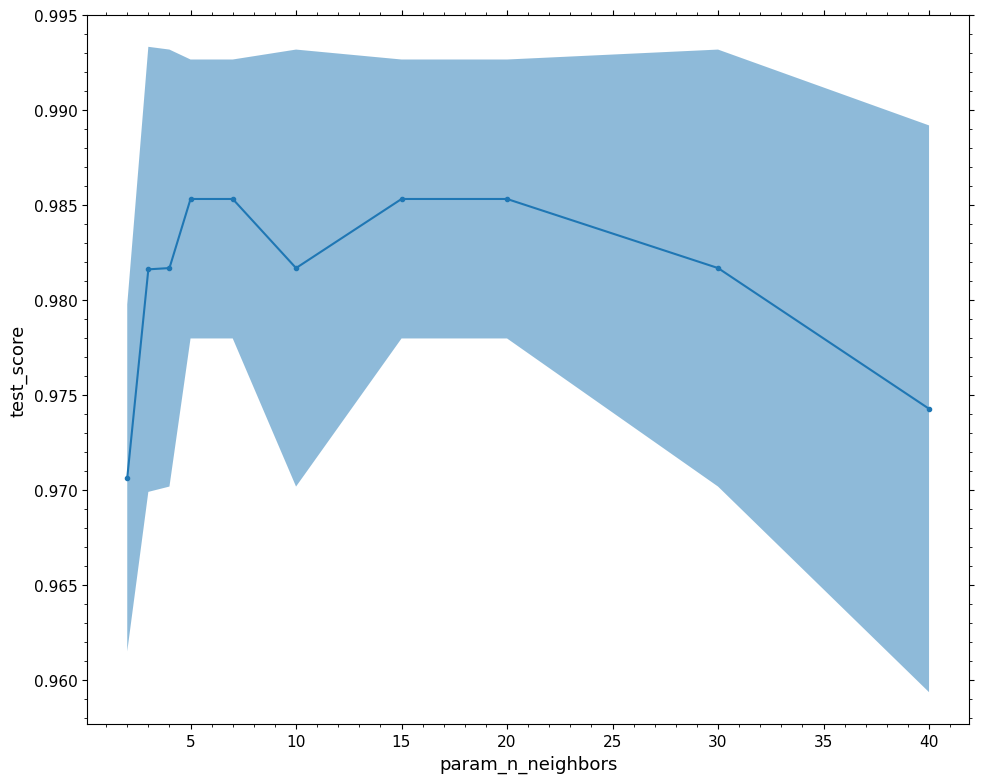

In [15]:
plt.figure(figsize=(10,8))
ax = plt.axes()
ax.plot(knn_results["param_n_neighbors"], knn_results["mean_test_score"], marker=".")
ax.fill_between(knn_results["param_n_neighbors"], knn_results["mean_test_score"] - knn_results["std_test_score"],
                knn_results["mean_test_score"] + knn_results["std_test_score"], alpha=.5)
ax.set_xlabel("param_n_neighbors")
ax.set_ylabel("test_score")
plt.show()

We see in the table that the best k parameter is tied amongst 5, 7, 15 and 20. According to Occam's Razor it is best to choose k=5 for this model, the smallest value. This also corresponds to the model with maximal stability according to the estimate for the standard deviation in accuracy.

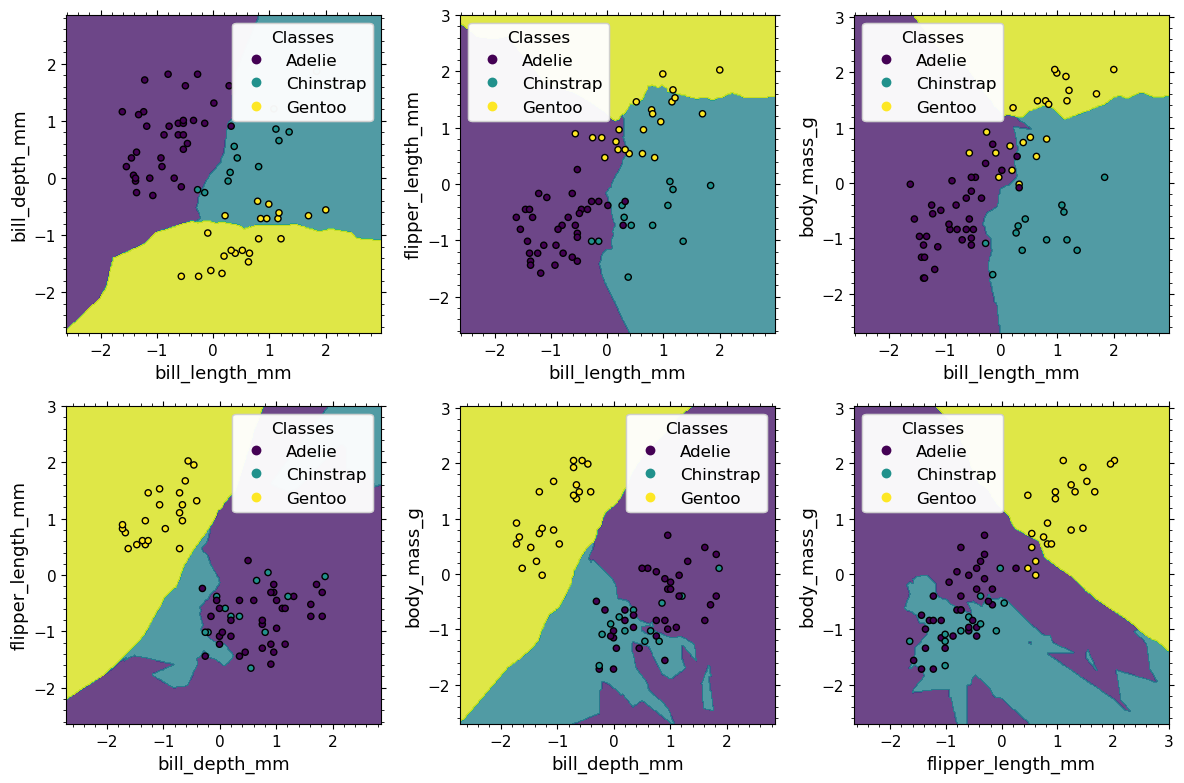

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], knn_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

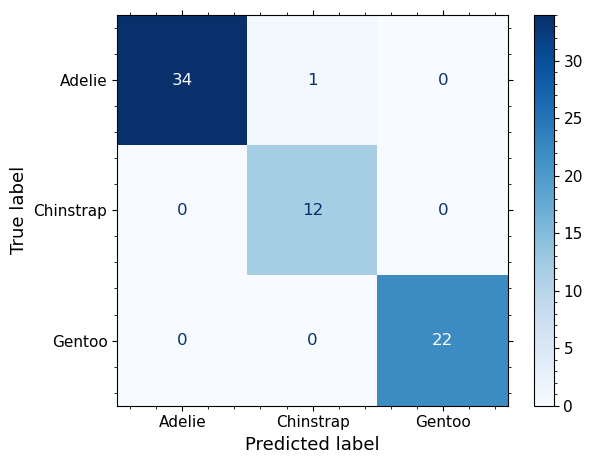

In [17]:
ConfusionMatrixDisplay.from_estimator(knn_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Support Vector Machine

In [18]:
svm_clf = SVC()
svm_cv = GridSearchCV(svm_clf, param_grid={"C":np.logspace(-1,3,5), "kernel":["linear", "poly", "rbf"]}, cv=5)
svm_cv.fit(X_train, y_train)
svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")
svm_results

/tmp/ipykernel_14573/766811450.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003116,0.000982,0.001498,0.000561,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,8.0
1,0.002915,0.000775,0.001180,0.000282,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.909091,0.890909,0.818182,0.851852,0.907407,0.875488,0.035294,15.0
2,0.004327,0.001784,0.001718,0.000543,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,8.0
3,0.002454,0.000811,0.002024,0.001157,1.0,linear,"{'C': 1.0, 'kernel': 'linear'}",1.000000,0.981818,0.981818,1.000000,0.981481,0.989024,0.008963,4.0
4,0.001954,0.000170,0.001804,0.001359,1.0,poly,"{'C': 1.0, 'kernel': 'poly'}",1.000000,0.981818,0.890909,0.962963,0.981481,0.963434,0.038107,14.0
5,0.002929,0.001119,0.001729,0.000707,1.0,rbf,"{'C': 1.0, 'kernel': 'rbf'}",1.000000,0.981818,0.981818,0.981481,0.981481,0.985320,0.007342,8.0
6,0.002591,0.000916,0.001363,0.000500,10.0,linear,"{'C': 10.0, 'kernel': 'linear'}",1.000000,1.000000,0.981818,0.981481,1.000000,0.992660,0.008990,3.0
7,0.003326,0.001730,0.001408,0.000714,10.0,poly,"{'C': 10.0, 'kernel': 'poly'}",0.981818,0.981818,0.927273,0.944444,1.000000,0.967071,0.026889,13.0
8,0.002286,0.000682,0.001700,0.000637,10.0,rbf,"{'C': 10.0, 'kernel': 'rbf'}",1.000000,0.981818,0.981818,0.981481,1.000000,0.989024,0.008963,4.0
9,0.001538,0.000551,0.000705,0.000208,100.0,linear,"{'C': 100.0, 'kernel': 'linear'}",1.000000,0.981818,0.963636,0.981481,1.000000,0.985387,0.013625,6.0


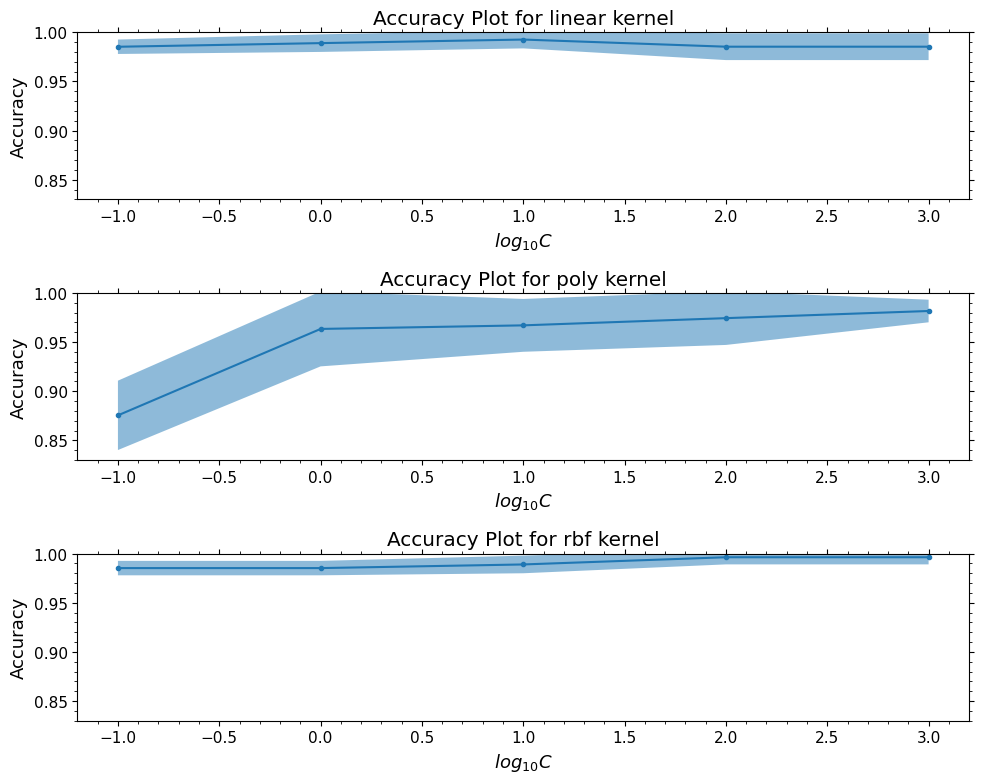

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))
for idx, kernel in enumerate(["linear", "poly", "rbf"]):
    svm_results_bykernel = svm_results[svm_results["param_kernel"] == kernel]
    ax[idx].plot(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"], marker=".")
    ax[idx].fill_between(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"] - svm_results_bykernel["std_test_score"],
                    svm_results_bykernel["mean_test_score"] + svm_results_bykernel["std_test_score"], alpha=.5)
    ax[idx].set_xlabel("$log_{10} C$")
    ax[idx].set_ylabel("Accuracy")
    ax[idx].set_title("Accuracy Plot for {} kernel".format(kernel))
    ax[idx].set_ylim((0.83,1.0))
plt.show()

We see that the best model is the SVM classifier using a radial basis function kernel and a regularisation term $C=100$. The fact that the accuracy improves with greater $C$ for the RBF kernel, unlike for the linear kernel, demonstrates that the RBF kernel makes the model more complex, and a greater $C$ avoids overfitting and help the model perform optimally. This model is also the most stable as can be seen above. The polynomial kernel is the least accurate/stable, but can come close to the other two models with a high enough regularisation ($C=1000$).

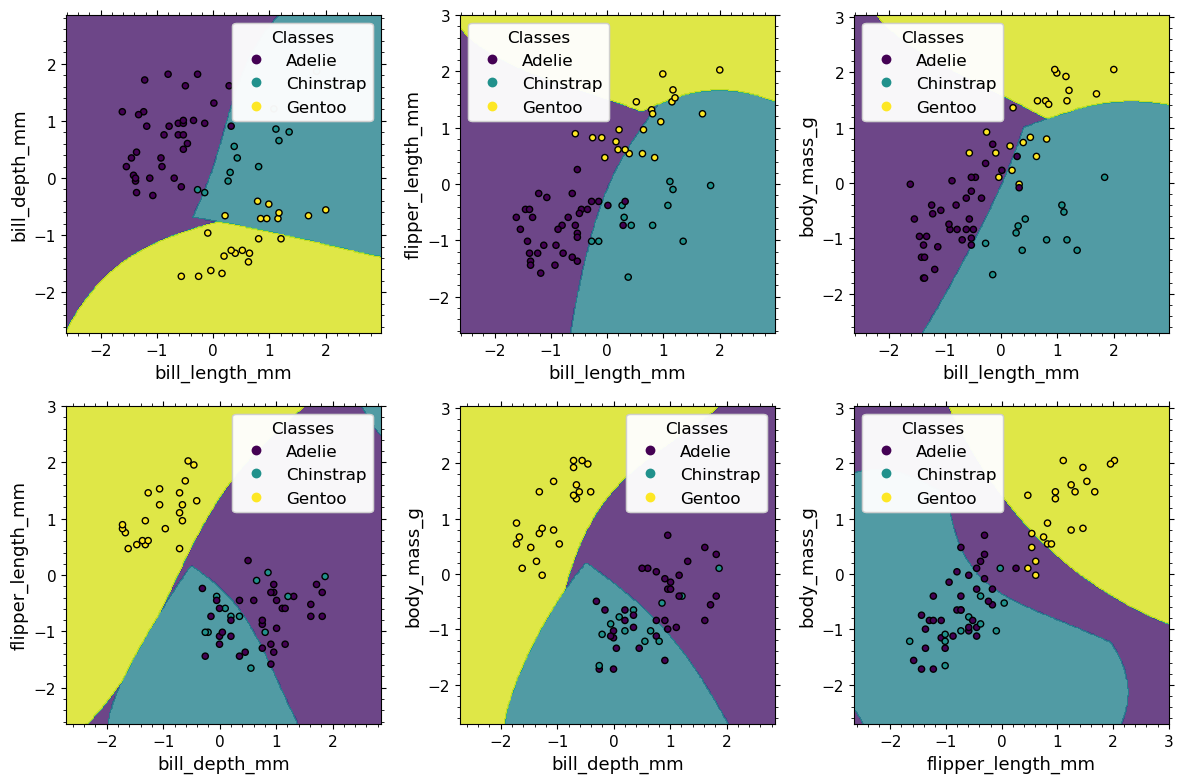

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], svm_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

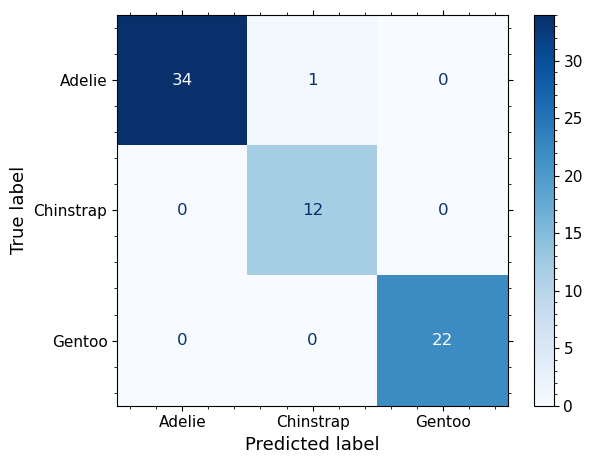

In [21]:
ConfusionMatrixDisplay.from_estimator(svm_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Linear Discriminant Analysis

In [22]:
lda_clf = LinearDiscriminantAnalysis()
lda_cv = GridSearchCV(lda_clf, param_grid={}, cv=5)
lda_cv.fit(X_train, y_train)
lda_results = pd.DataFrame(lda_cv.cv_results_, dtype="float64")
lda_results

/tmp/ipykernel_14573/2525302351.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  lda_results = pd.DataFrame(lda_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003563,0.002682,0.001251,0.000929,{},1.0,0.981818,0.981818,1.0,0.981481,0.989024,0.008963,1.0


In [23]:
lda_cv.best_estimator_.intercept_

array([ -7.58496179,  -8.09165386, -14.27324798])

In [24]:
lda_cv.best_estimator_.coef_

array([[ -4.26337096,   7.06649511,  -4.31759276,  -2.22401661],
       [  5.85354892,   4.63122019,  -3.39777168,  -5.98514911],
       [  1.65101279, -10.68377984,   6.84273242,   5.87281463]])

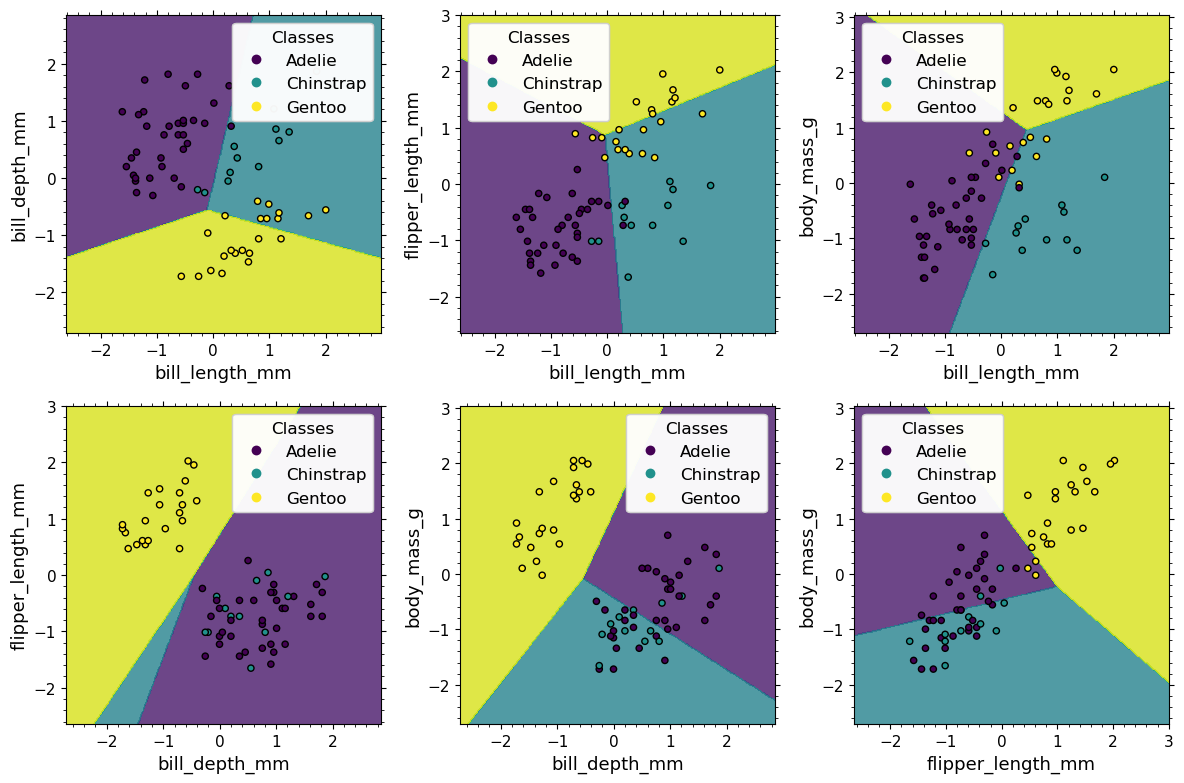

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], lda_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

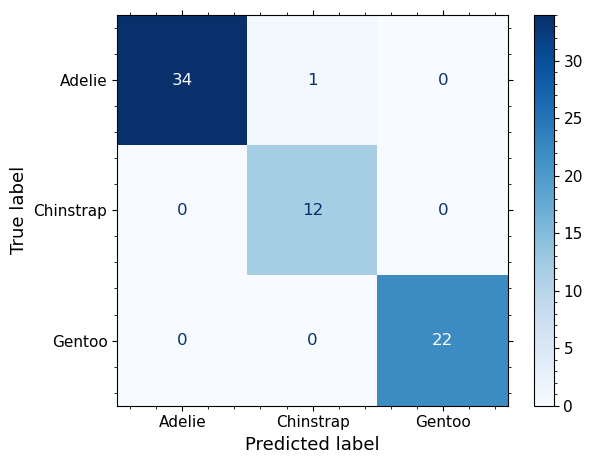

In [26]:
ConfusionMatrixDisplay.from_estimator(lda_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Quadratic Discriminant Analysis

In [27]:
qda_clf = QuadraticDiscriminantAnalysis()
qda_cv = GridSearchCV(qda_clf, param_grid={}, cv=5)
qda_cv.fit(X_train, y_train)
qda_results = pd.DataFrame(qda_cv.cv_results_, dtype="float64")
qda_results

/tmp/ipykernel_14573/1998898688.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  qda_results = pd.DataFrame(qda_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002035,0.001041,0.00126,0.000463,{},1.0,0.981818,0.981818,0.981481,1.0,0.989024,0.008963,1.0


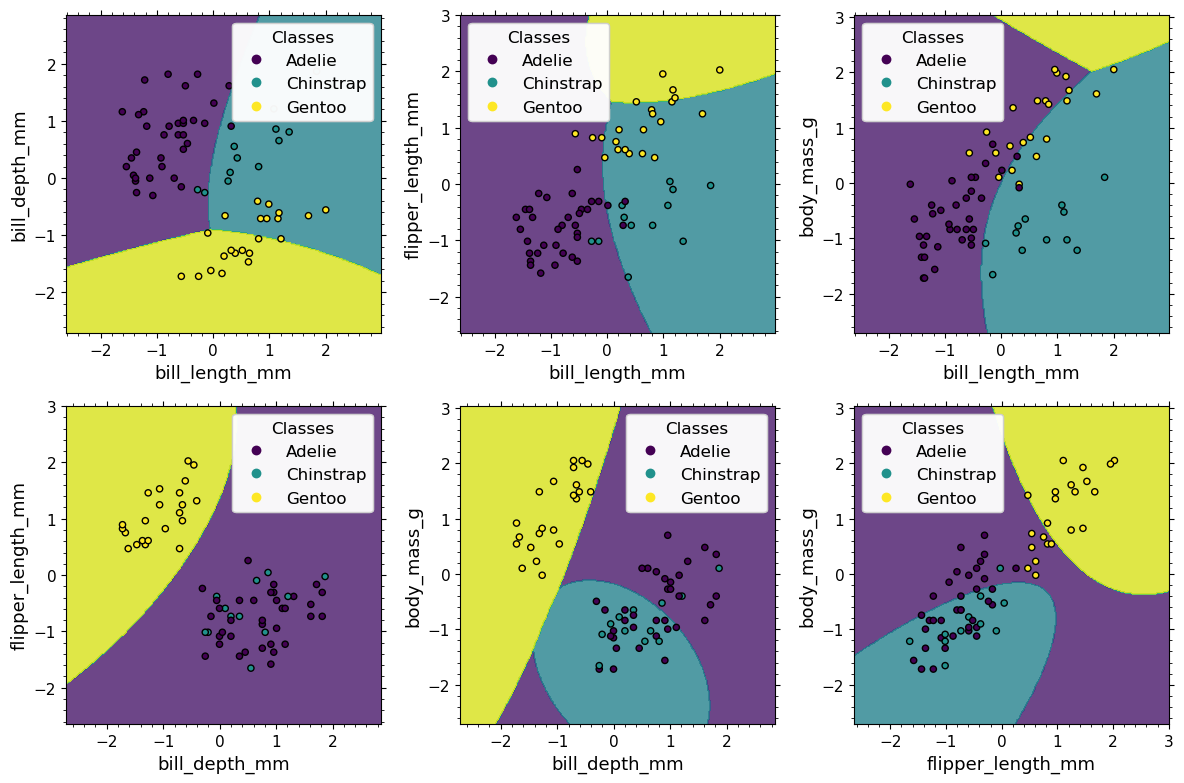

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], qda_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

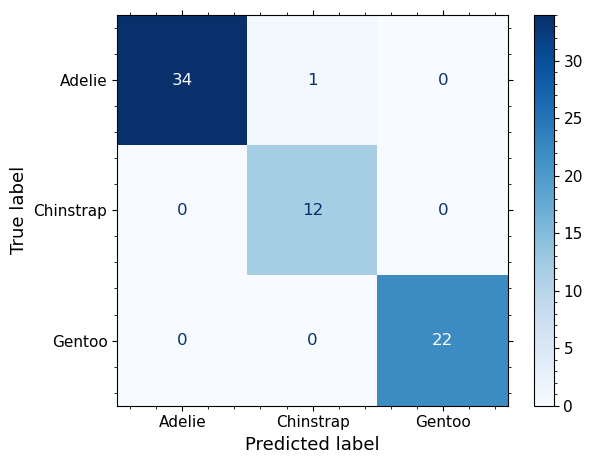

In [29]:
ConfusionMatrixDisplay.from_estimator(qda_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

As we can see, in all cases the evaluation on the test data is the same with almost 100% accuracy, which reflects the separability of the classes.

## Question 1: Dataset with Outliers

In [30]:
X = np.array(penguins_df.drop(columns=["species"]))
label_ec = LabelEncoder()
y = label_ec.fit_transform(penguins_df["species"])

In [31]:
g = np.random.default_rng(seed=42)

rnd_idx = g.choice(range(len(X)), 20)
outliers_X = X[rnd_idx, :] + g.multivariate_normal([0,0,0,0], np.diag(np.array(0.1*penguins_df.describe(include=["float", "int"]).loc["std"])), 20)
outliers_y = (y[rnd_idx] + 1) % 3

In [32]:
X = np.vstack([X, outliers_X])
y = np.hstack([y, outliers_y])

We introduce outliers by choosing data points at random, adding some noise to their predictor values, and swapping their class labels.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression

In [34]:
lr_clf = LogisticRegression()
lr_cv = GridSearchCV(lr_clf, param_grid={}, cv=5)
lr_cv.fit(X_train, y_train)
lr_results = pd.DataFrame(lr_cv.cv_results_, dtype="float64")
lr_results

/tmp/ipykernel_14573/631065594.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  lr_results = pd.DataFrame(lr_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008692,0.003072,0.000806,0.000202,{},0.896552,0.913793,0.965517,0.931034,0.894737,0.920327,0.026152,1.0


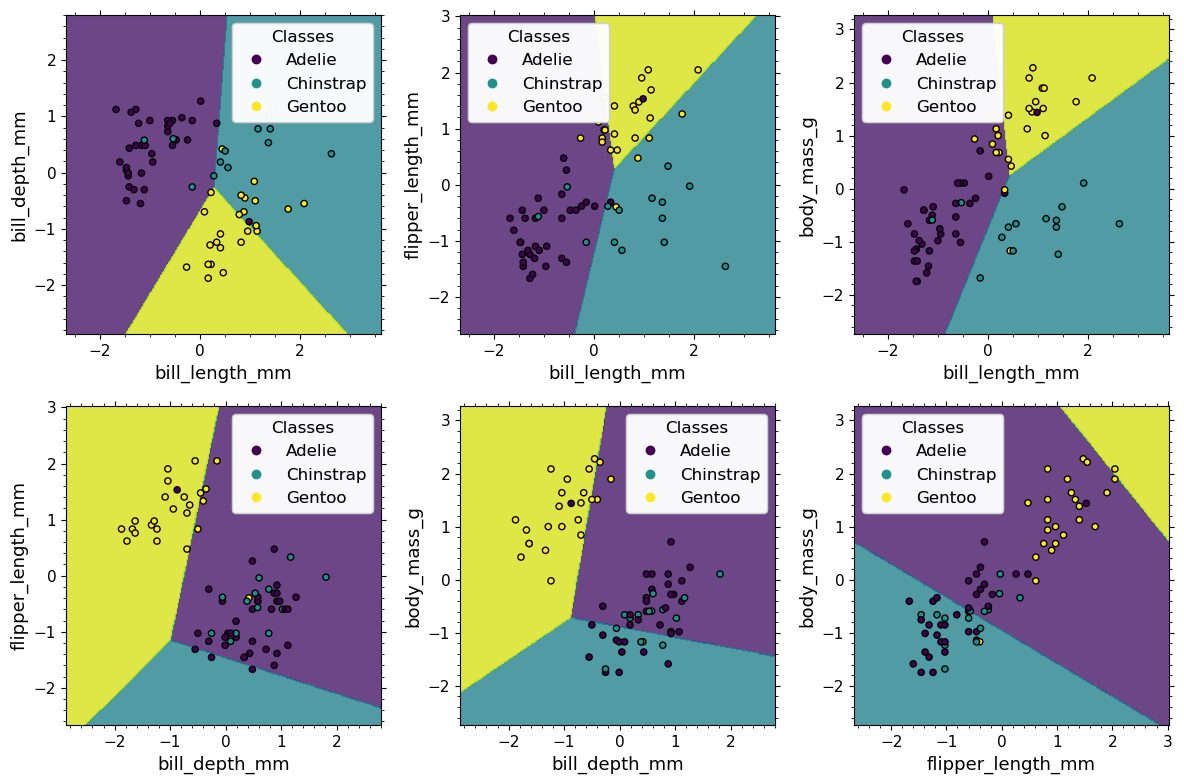

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], lr_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

In [68]:
pd.DataFrame(np.hstack([lr_cv.best_estimator_.intercept_.reshape(-1,1), lr_cv.best_estimator_.coef_]),
    columns = ["intercept"]+["coef_"+feat for feat in ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]],
    index = ["Adelie", "Chinstrap", "Gentoo"]
)

,intercept,coef_bill_length_mm,coef_bill_depth_mm,coef_flipper_length_mm,coef_body_mass_g
Adelie,0.856512,-2.166977,0.692901,0.231005,0.472240
Chinstrap,-0.549983,1.767960,0.355025,-0.827032,-1.227022
Gentoo,-0.306529,0.399017,-1.047927,0.596027,0.754782


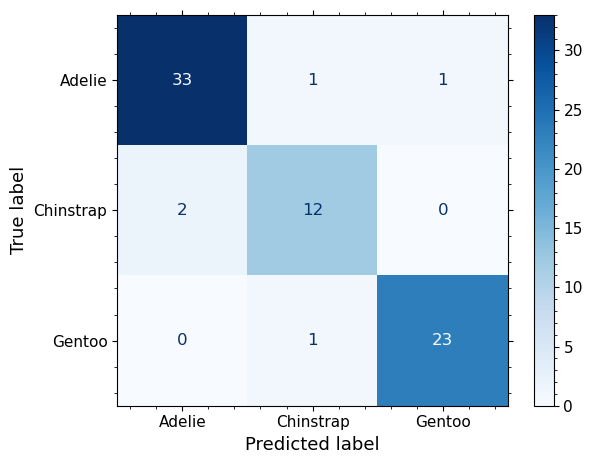

In [38]:
ConfusionMatrixDisplay.from_estimator(lr_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Nearest Neighbours

In [39]:
knn_clf = KNeighborsClassifier()
knn_cv = GridSearchCV(knn_clf, param_grid={"n_neighbors":[2, 3, 4, 5, 7, 10, 15, 20, 30, 40]}, cv=5)
knn_cv.fit(X_train, y_train)
knn_results = pd.DataFrame(knn_cv.cv_results_, dtype="float64")
knn_results

/tmp/ipykernel_14573/1387840006.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  knn_results = pd.DataFrame(knn_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001918,0.000812,0.009962,0.003093,2.0,{'n_neighbors': 2},0.879310,0.879310,0.879310,0.862069,0.824561,0.864912,0.021252,10.0
1,0.001011,0.000384,0.006433,0.001588,3.0,{'n_neighbors': 3},0.896552,0.948276,0.931034,0.931034,0.877193,0.916818,0.025980,9.0
2,0.000894,0.000171,0.007309,0.001191,4.0,{'n_neighbors': 4},0.931034,0.948276,0.931034,0.913793,0.894737,0.923775,0.018158,3.0
3,0.000891,0.000305,0.006108,0.001669,5.0,{'n_neighbors': 5},0.913793,0.965517,0.948276,0.931034,0.894737,0.930672,0.024902,1.0
4,0.001056,0.000360,0.007355,0.001786,7.0,{'n_neighbors': 7},0.931034,0.948276,0.965517,0.913793,0.894737,0.930672,0.024902,1.0
5,0.001172,0.000638,0.008196,0.002226,10.0,{'n_neighbors': 10},0.931034,0.948276,0.948276,0.896552,0.894737,0.923775,0.023823,3.0
6,0.000751,0.000178,0.005772,0.001297,15.0,{'n_neighbors': 15},0.931034,0.948276,0.948276,0.896552,0.894737,0.923775,0.023823,3.0
7,0.000992,0.000768,0.005032,0.001181,20.0,{'n_neighbors': 20},0.931034,0.948276,0.948276,0.896552,0.894737,0.923775,0.023823,3.0
8,0.000734,0.000168,0.005053,0.000878,30.0,{'n_neighbors': 30},0.931034,0.948276,0.948276,0.896552,0.894737,0.923775,0.023823,3.0
9,0.000712,0.000108,0.005139,0.001262,40.0,{'n_neighbors': 40},0.913793,0.948276,0.948276,0.896552,0.894737,0.920327,0.023770,8.0


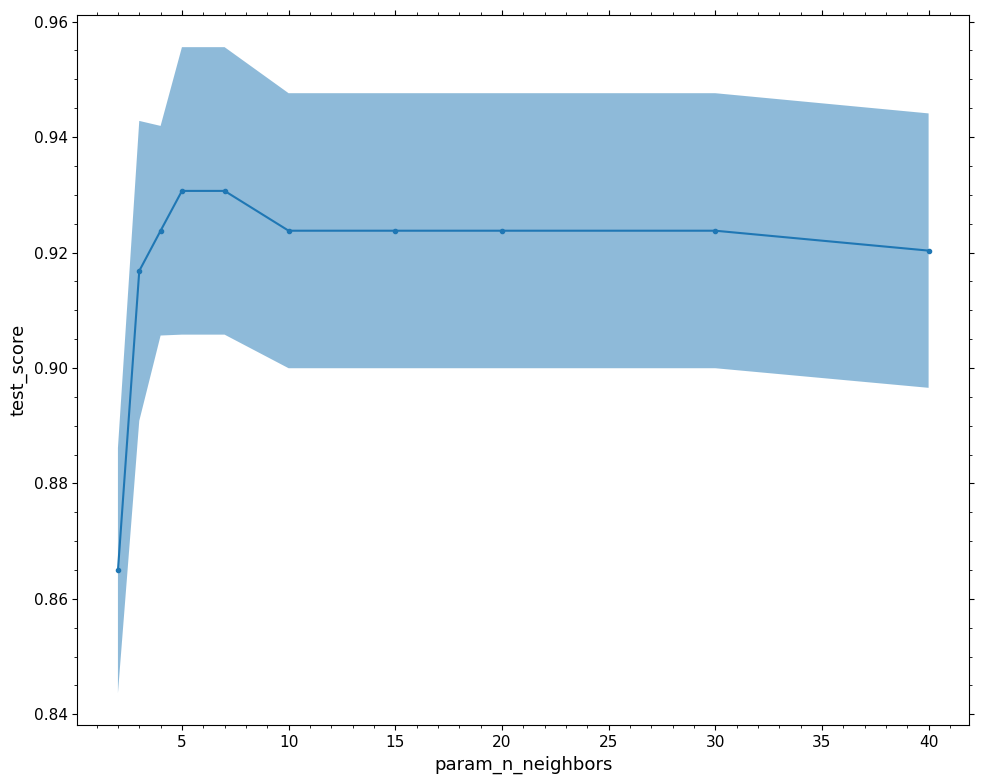

In [40]:
plt.figure(figsize=(10,8))
ax = plt.axes()
ax.plot(knn_results["param_n_neighbors"], knn_results["mean_test_score"], marker=".")
ax.fill_between(knn_results["param_n_neighbors"], knn_results["mean_test_score"] - knn_results["std_test_score"],
                knn_results["mean_test_score"] + knn_results["std_test_score"], alpha=.5)
ax.set_xlabel("param_n_neighbors")
ax.set_ylabel("test_score")
plt.show()

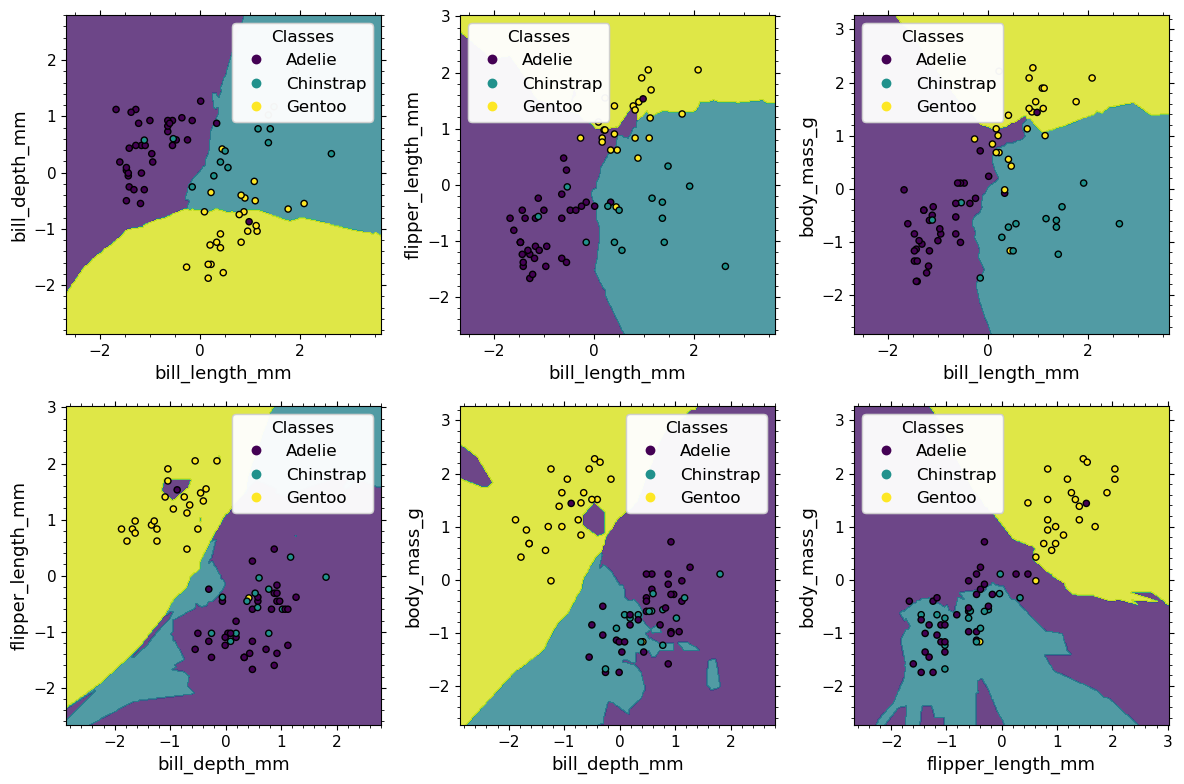

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], knn_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

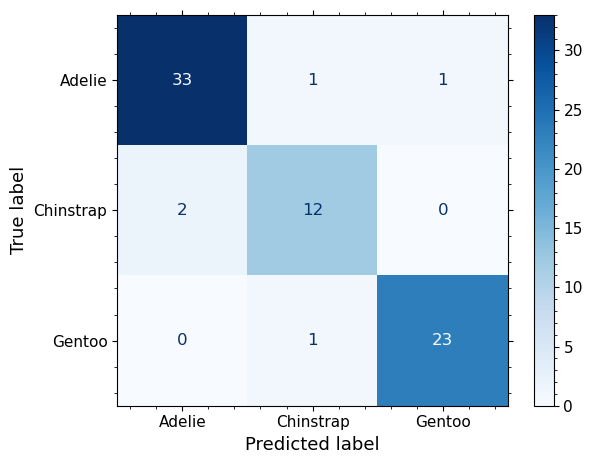

In [42]:
ConfusionMatrixDisplay.from_estimator(knn_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Support Vector Machine

In [43]:
svm_clf = SVC()
svm_cv = GridSearchCV(svm_clf, param_grid={"C":np.logspace(-1,3,5), "kernel":["linear", "poly", "rbf"]}, cv=5)
svm_cv.fit(X_train, y_train)
svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")
svm_results

/tmp/ipykernel_14573/766811450.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003652,0.002531,0.002139,0.001969,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.913793,0.948276,0.931034,0.896552,0.894737,0.916878,0.020490,5.0
1,0.004027,0.001351,0.002330,0.001501,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.793103,0.810345,0.810345,0.793103,0.807018,0.802783,0.007996,15.0
2,0.006306,0.001543,0.002596,0.001103,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.931034,0.948276,0.948276,0.913793,0.894737,0.927223,0.020672,1.0
3,0.002064,0.000543,0.001587,0.001416,1.0,linear,"{'C': 1.0, 'kernel': 'linear'}",0.896552,0.948276,0.948276,0.931034,0.894737,0.923775,0.023823,3.0
4,0.003387,0.001481,0.001212,0.000508,1.0,poly,"{'C': 1.0, 'kernel': 'poly'}",0.896552,0.879310,0.879310,0.827586,0.877193,0.871990,0.023278,12.0
5,0.002991,0.000551,0.002100,0.001261,1.0,rbf,"{'C': 1.0, 'kernel': 'rbf'}",0.931034,0.948276,0.948276,0.913793,0.894737,0.927223,0.020672,1.0
6,0.004388,0.000780,0.001527,0.000876,10.0,linear,"{'C': 10.0, 'kernel': 'linear'}",0.879310,0.931034,0.965517,0.913793,0.894737,0.916878,0.029924,5.0
7,0.003409,0.000859,0.001146,0.000514,10.0,poly,"{'C': 10.0, 'kernel': 'poly'}",0.896552,0.896552,0.862069,0.913793,0.894737,0.892740,0.016834,10.0
8,0.003554,0.001054,0.001483,0.000299,10.0,rbf,"{'C': 10.0, 'kernel': 'rbf'}",0.896552,0.965517,0.948276,0.913793,0.877193,0.920266,0.032532,4.0
9,0.013432,0.003682,0.001626,0.001230,100.0,linear,"{'C': 100.0, 'kernel': 'linear'}",0.879310,0.913793,0.965517,0.913793,0.877193,0.909921,0.032028,7.0


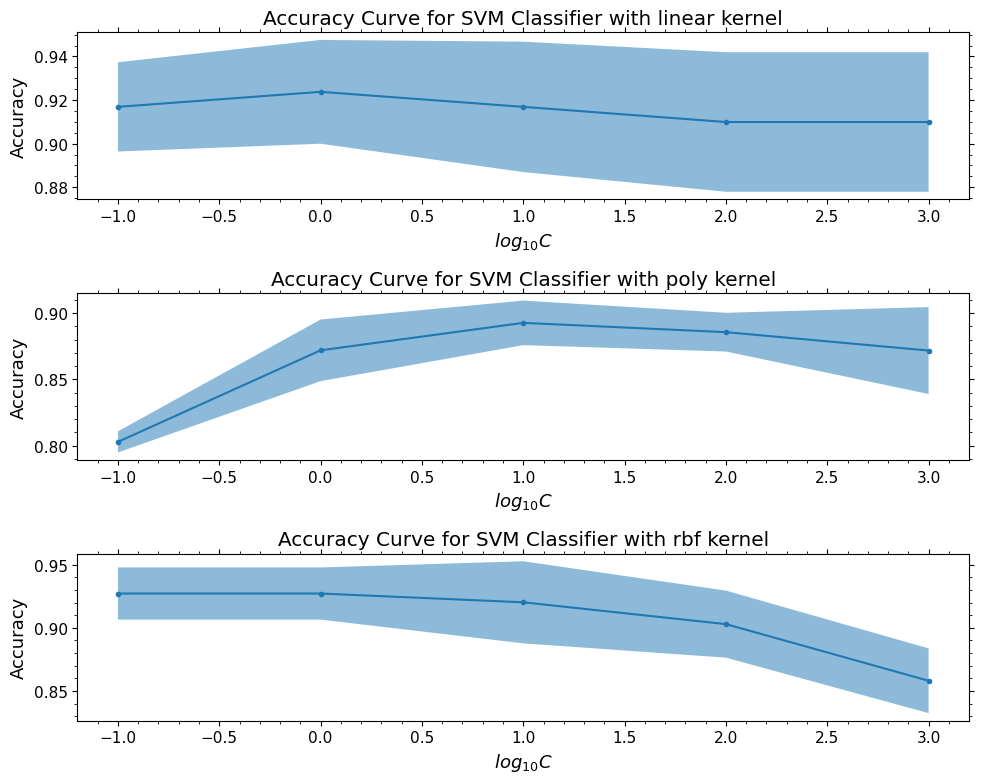

In [44]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))
for idx, kernel in enumerate(["linear", "poly", "rbf"]):
    svm_results_bykernel = svm_results[svm_results["param_kernel"] == kernel]
    ax[idx].plot(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"], marker=".")
    ax[idx].fill_between(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"] - svm_results_bykernel["std_test_score"],
                    svm_results_bykernel["mean_test_score"] + svm_results_bykernel["std_test_score"], alpha=.5)
    ax[idx].set_xlabel("$log_{10} C$")
    ax[idx].set_ylabel("Accuracy")
    ax[idx].set_title("Accuracy Curve for SVM Classifier with {} kernel".format(kernel))
plt.show()

Again the RBF kernel performs the best, however we see that the optimal regularisation constant is lower at $C=1$, whereas it was $100$ before. The standard deviation of the accuracy of this best model is over twice that of the accuracy of the best model for the original data, reflecting a fall in stability of the model.

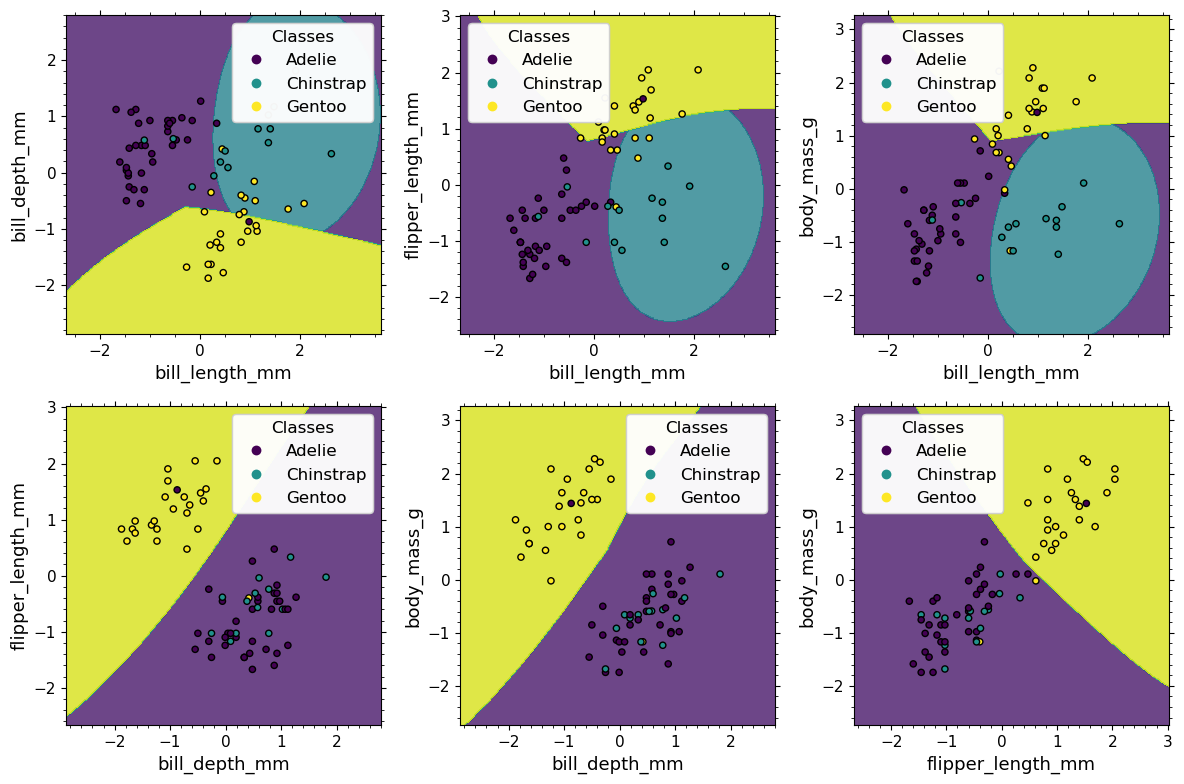

In [45]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], svm_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

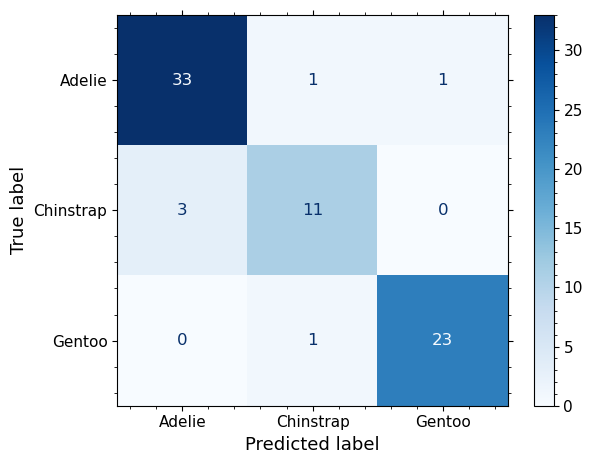

In [46]:
ConfusionMatrixDisplay.from_estimator(svm_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Linear Discriminant Analysis

In [47]:
lda_clf = LinearDiscriminantAnalysis()
lda_cv = GridSearchCV(lda_clf, param_grid={}, cv=5)
lda_cv.fit(X_train, y_train)
lda_results = pd.DataFrame(lda_cv.cv_results_, dtype="float64")
lda_results

/tmp/ipykernel_14573/2525302351.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  lda_results = pd.DataFrame(lda_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002635,0.001115,0.001049,0.000343,{},0.913793,0.965517,0.965517,0.931034,0.894737,0.93412,0.02809,1.0


In [48]:
lda_cv.best_estimator_.intercept_

array([-2.5318187 , -5.00145066, -4.50810104])

In [49]:
lda_cv.best_estimator_.coef_

array([[-2.46419207,  1.76491735, -0.4352103 , -0.01509771],
       [ 4.65967539,  1.20831342, -1.8340417 , -3.27041819],
       [ 0.25733335, -2.90281084,  1.63444159,  1.97448845]])

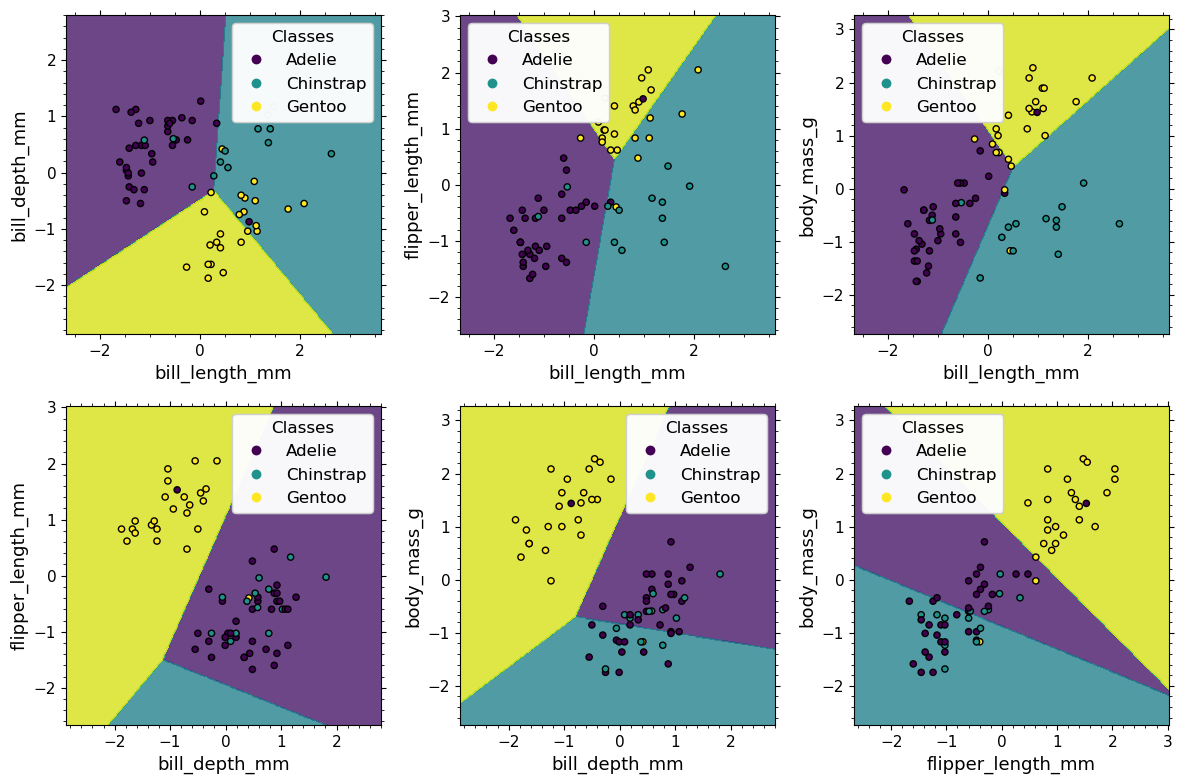

In [50]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], lda_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

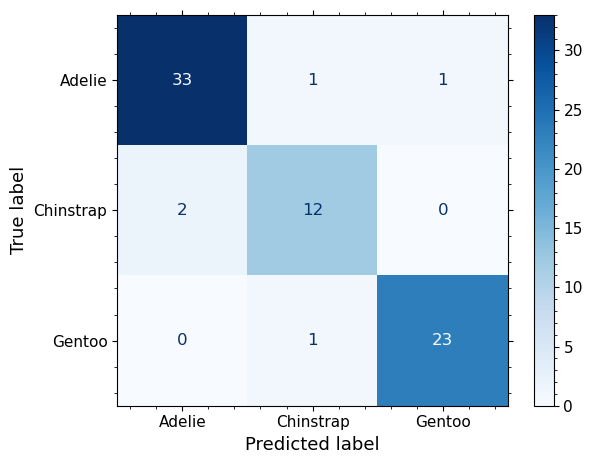

In [51]:
ConfusionMatrixDisplay.from_estimator(lda_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

### Quadratic Discriminant Analysis

In [52]:
qda_clf = QuadraticDiscriminantAnalysis()
qda_cv = GridSearchCV(qda_clf, param_grid={}, cv=5)
qda_cv.fit(X_train, y_train)
qda_results = pd.DataFrame(qda_cv.cv_results_, dtype="float64")
qda_results

/tmp/ipykernel_14573/1998898688.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  qda_results = pd.DataFrame(qda_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003118,0.00204,0.001495,0.000353,{},0.913793,0.948276,0.948276,0.931034,0.894737,0.927223,0.020672,1.0


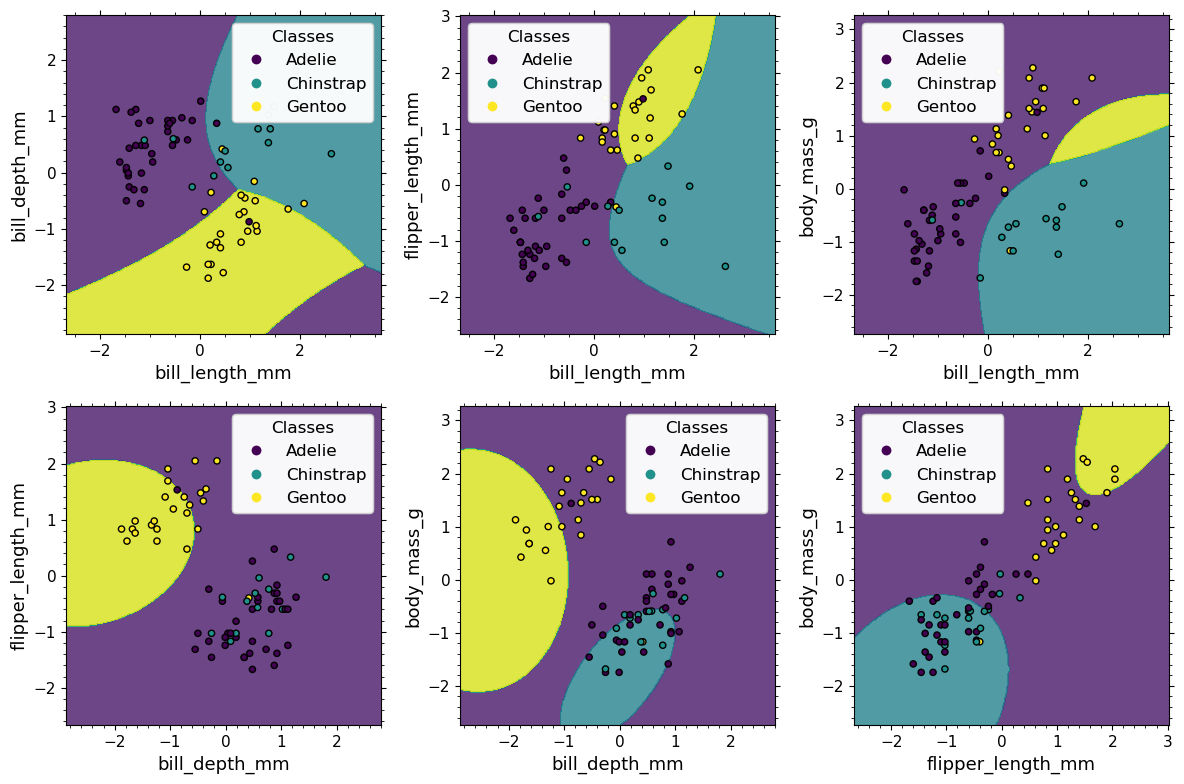

In [53]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))
for idx, pair in enumerate(combinations(enumerate(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]), 2)):
    plot_decision_boundary(ax[idx // 3, idx % 3], qda_cv.best_estimator_, X_test, y_test, label_ec.classes_, pair[0][0], pair[1][0])
    ax[idx // 3, idx % 3].set_xlabel(pair[0][1])
    ax[idx // 3, idx % 3].set_ylabel(pair[1][1])
plt.show()

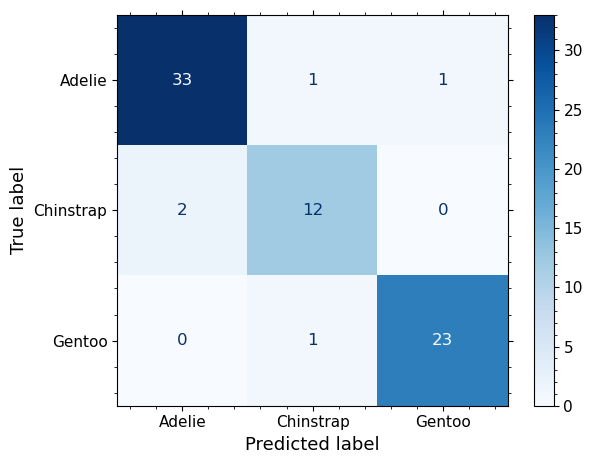

In [54]:
ConfusionMatrixDisplay.from_estimator(qda_cv.best_estimator_, X_test, y_test, display_labels=label_ec.classes_, cmap=plt.cm.Blues)
plt.show()

We can see that in all cases, the models are less stable; for instance in the generative approaches the standard devation of the accuracy more than doubled compared to before. However, all models seem equally affected by the presence of outliers, with similar confusion matrices, and fairly similar decision boundaries / hyperparameters, apart from the case of the C value in the SVM model.

## Question 2

### Question 2.a.

In [55]:
digits = load_digits()
X = digits["data"]
y = digits["target"]
print("Data contains {} samples of handwritten digit images, with {} features (pixels) each.".format(*X.shape))

Data contains 1797 samples of handwritten digit images, with 64 features (pixels) each.


In [56]:
print("Frequency of each digit:")
pd.DataFrame(pd.value_counts(y), columns=["Count"])

Frequency of each digit:


,Count
3,183
1,182
5,182
4,181
6,181
9,180
7,179
0,178
2,177
8,174


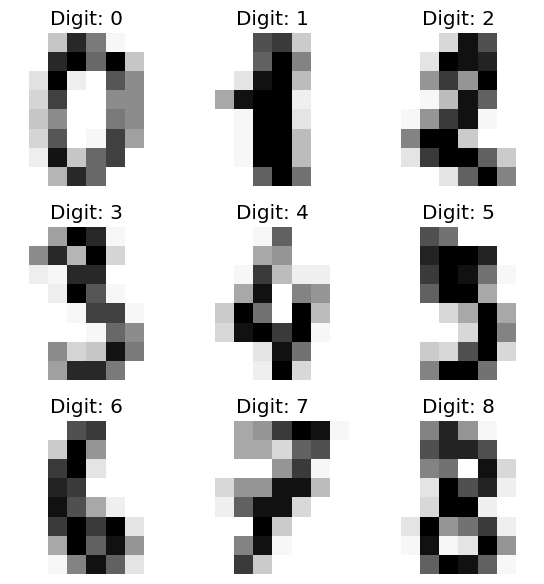

In [57]:
fig, ax = plt.subplots(3,3,figsize=(6,6))
for idx in range(9):
    ax[idx // 3, idx % 3].imshow(X[idx].reshape((8,8)), cmap="Greys")
    ax[idx // 3, idx % 3].axis("off")
    ax[idx // 3, idx % 3].set_title("Digit: {}".format(y[idx]))

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [59]:
svm_clf = SVC()
svm_cv = GridSearchCV(svm_clf, param_grid={"C":np.logspace(-1,3,5), "kernel":["linear", "poly", "rbf"]}, cv=10)
svm_cv.fit(X_train, y_train)
svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")
svm_results

/tmp/ipykernel_14573/3302014323.py:4: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039611,0.005154,0.005647,0.002317,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.981481,0.981481,0.993827,0.981481,0.987654,0.956790,0.987654,0.981366,0.975155,0.962733,0.978963,0.010800,10.0
1,0.083832,0.008087,0.012174,0.002429,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.981481,0.987654,0.975309,0.981481,0.987654,0.962963,0.987654,0.981366,0.968944,0.993789,0.980830,0.008943,9.0
2,0.131278,0.036519,0.021967,0.005467,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.956790,0.969136,0.956790,0.944444,0.962963,0.944444,0.981481,0.962733,0.937888,0.962733,0.957940,0.012328,15.0
3,0.024597,0.001225,0.003404,0.000851,1.0,linear,"{'C': 1.0, 'kernel': 'linear'}",0.981481,0.981481,0.993827,0.981481,0.987654,0.956790,0.987654,0.981366,0.975155,0.962733,0.978963,0.010800,10.0
4,0.038818,0.009680,0.005002,0.001840,1.0,poly,"{'C': 1.0, 'kernel': 'poly'}",1.000000,0.987654,0.987654,0.981481,0.993827,0.981481,1.000000,0.993789,0.993789,0.993789,0.991347,0.006291,4.0
5,0.044000,0.003138,0.010860,0.001502,1.0,rbf,"{'C': 1.0, 'kernel': 'rbf'}",0.993827,0.987654,0.993827,0.981481,0.987654,0.975309,0.987654,0.993789,0.975155,1.000000,0.987635,0.007829,8.0
6,0.036045,0.009166,0.004949,0.001966,10.0,linear,"{'C': 10.0, 'kernel': 'linear'}",0.981481,0.981481,0.993827,0.981481,0.987654,0.956790,0.987654,0.981366,0.975155,0.962733,0.978963,0.010800,10.0
7,0.039263,0.006875,0.006570,0.001996,10.0,poly,"{'C': 10.0, 'kernel': 'poly'}",0.993827,0.987654,0.987654,0.981481,0.993827,0.981481,0.993827,0.993789,0.987578,0.993789,0.989491,0.004817,5.0
8,0.061299,0.017530,0.013361,0.002982,10.0,rbf,"{'C': 10.0, 'kernel': 'rbf'}",1.000000,0.987654,0.987654,0.987654,0.993827,0.981481,1.000000,0.993789,1.000000,1.000000,0.993206,0.006444,1.0
9,0.025673,0.002294,0.003334,0.000758,100.0,linear,"{'C': 100.0, 'kernel': 'linear'}",0.981481,0.981481,0.993827,0.981481,0.987654,0.956790,0.987654,0.981366,0.975155,0.962733,0.978963,0.010800,10.0


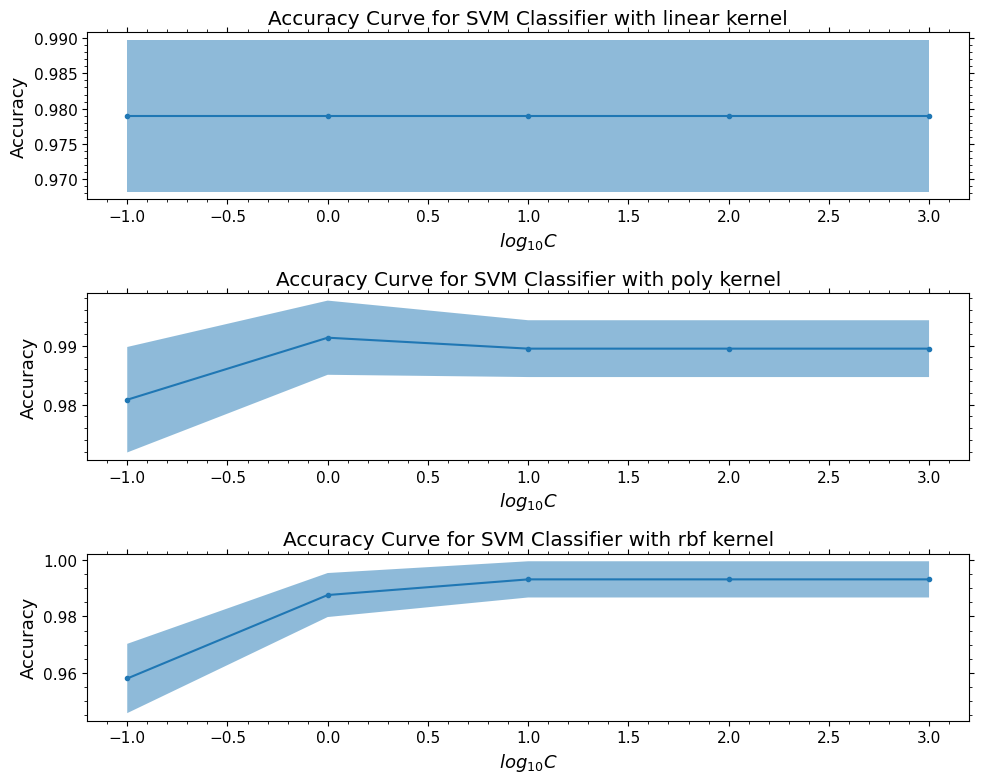

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(10,8))
for idx, kernel in enumerate(["linear", "poly", "rbf"]):
    svm_results_bykernel = svm_results[svm_results["param_kernel"] == kernel]
    ax[idx].plot(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"], marker=".")
    ax[idx].fill_between(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"] - svm_results_bykernel["std_test_score"],
                    svm_results_bykernel["mean_test_score"] + svm_results_bykernel["std_test_score"], alpha=.5)
    ax[idx].set_xlabel("$log_{10} C$")
    ax[idx].set_ylabel("Accuracy")
    ax[idx].set_title("Accuracy Curve for SVM Classifier with {} kernel".format(kernel))
plt.show()

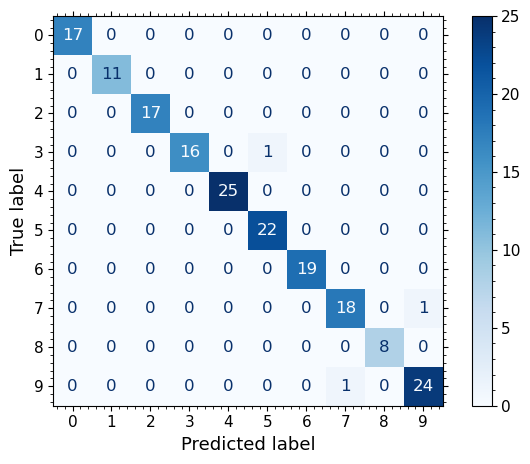

In [61]:
ConfusionMatrixDisplay.from_estimator(svm_cv.best_estimator_, X_test, y_test, display_labels=np.unique(y), cmap=plt.cm.Blues)
plt.show()

We can see that an SVM with a RBF kernel and $C>10$ is optimal. This reflects the highly non-linear nature of the features (since they are image pixels), which equally explains why the linear kernel appears to perform the worst in this case.

### Question 2.b.

/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 10.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.043390
1          poly      0.1        0.069186
2           rbf      0.1        0.041202
3        linear      1.0        0.043390
4          poly      1.0        0.058041
5           rbf      1.0        0.043033
6        linear     10.0        0.043390
7          poly     10.0        0.054509
8           rbf     10.0        0.044444
9        linear    100.0        0.043390
10         poly    100.0        0.054509
11          rbf    100.0        0.044444
12       linear   1000.0        0.043390
13         poly   1000.0        0.054509
14          rbf   1000.0        0.044444
Best train accuracy: 1.0000 Test accuracy: 0.9499
Best train F1-score: 1.0000 Test F1-score: 0.9498
********** 




/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 25.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.020367
1          poly      0.1        0.030170
2           rbf      0.1        0.045758
3        linear      1.0        0.020367
4          poly      1.0        0.022643
5           rbf      1.0        0.028435
6        linear     10.0        0.020367
7          poly     10.0        0.019984
8           rbf     10.0        0.018466
9        linear    100.0        0.020367
10         poly    100.0        0.019984
11          rbf    100.0        0.018466
12       linear   1000.0        0.020367
13         poly   1000.0        0.019984
14          rbf   1000.0        0.018466
Best train accuracy: 1.0000 Test accuracy: 0.9770
Best train F1-score: 1.0000 Test F1-score: 0.9770
********** 




/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 50.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.018035
1          poly      0.1        0.019092
2           rbf      0.1        0.024372
3        linear      1.0        0.018035
4          poly      1.0        0.009681
5           rbf      1.0        0.020155
6        linear     10.0        0.018035
7          poly     10.0        0.010167
8           rbf     10.0        0.011600
9        linear    100.0        0.018035
10         poly    100.0        0.010167
11          rbf    100.0        0.011600
12       linear   1000.0        0.018035
13         poly   1000.0        0.010167
14          rbf   1000.0        0.011600
Best train accuracy: 1.0000 Test accuracy: 0.9844
Best train F1-score: 1.0000 Test F1-score: 0.9846
********** 




/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 75.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.014207
1          poly      0.1        0.012733
2           rbf      0.1        0.017057
3        linear      1.0        0.014207
4          poly      1.0        0.008890
5           rbf      1.0        0.005937
6        linear     10.0        0.014207
7          poly     10.0        0.008890
8           rbf     10.0        0.008412
9        linear    100.0        0.014207
10         poly    100.0        0.008890
11          rbf    100.0        0.008412
12       linear   1000.0        0.014207
13         poly   1000.0        0.008890
14          rbf   1000.0        0.008412
Best train accuracy: 1.0000 Test accuracy: 0.9889
Best train F1-score: 1.0000 Test F1-score: 0.9890
********** 




/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 90.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.010800
1          poly      0.1        0.008943
2           rbf      0.1        0.012328
3        linear      1.0        0.010800
4          poly      1.0        0.006291
5           rbf      1.0        0.007829
6        linear     10.0        0.010800
7          poly     10.0        0.004817
8           rbf     10.0        0.006444
9        linear    100.0        0.010800
10         poly    100.0        0.004817
11          rbf    100.0        0.006444
12       linear   1000.0        0.010800
13         poly   1000.0        0.004817
14          rbf   1000.0        0.006444
Best train accuracy: 1.0000 Test accuracy: 0.9833
Best train F1-score: 1.0000 Test F1-score: 0.9855
********** 




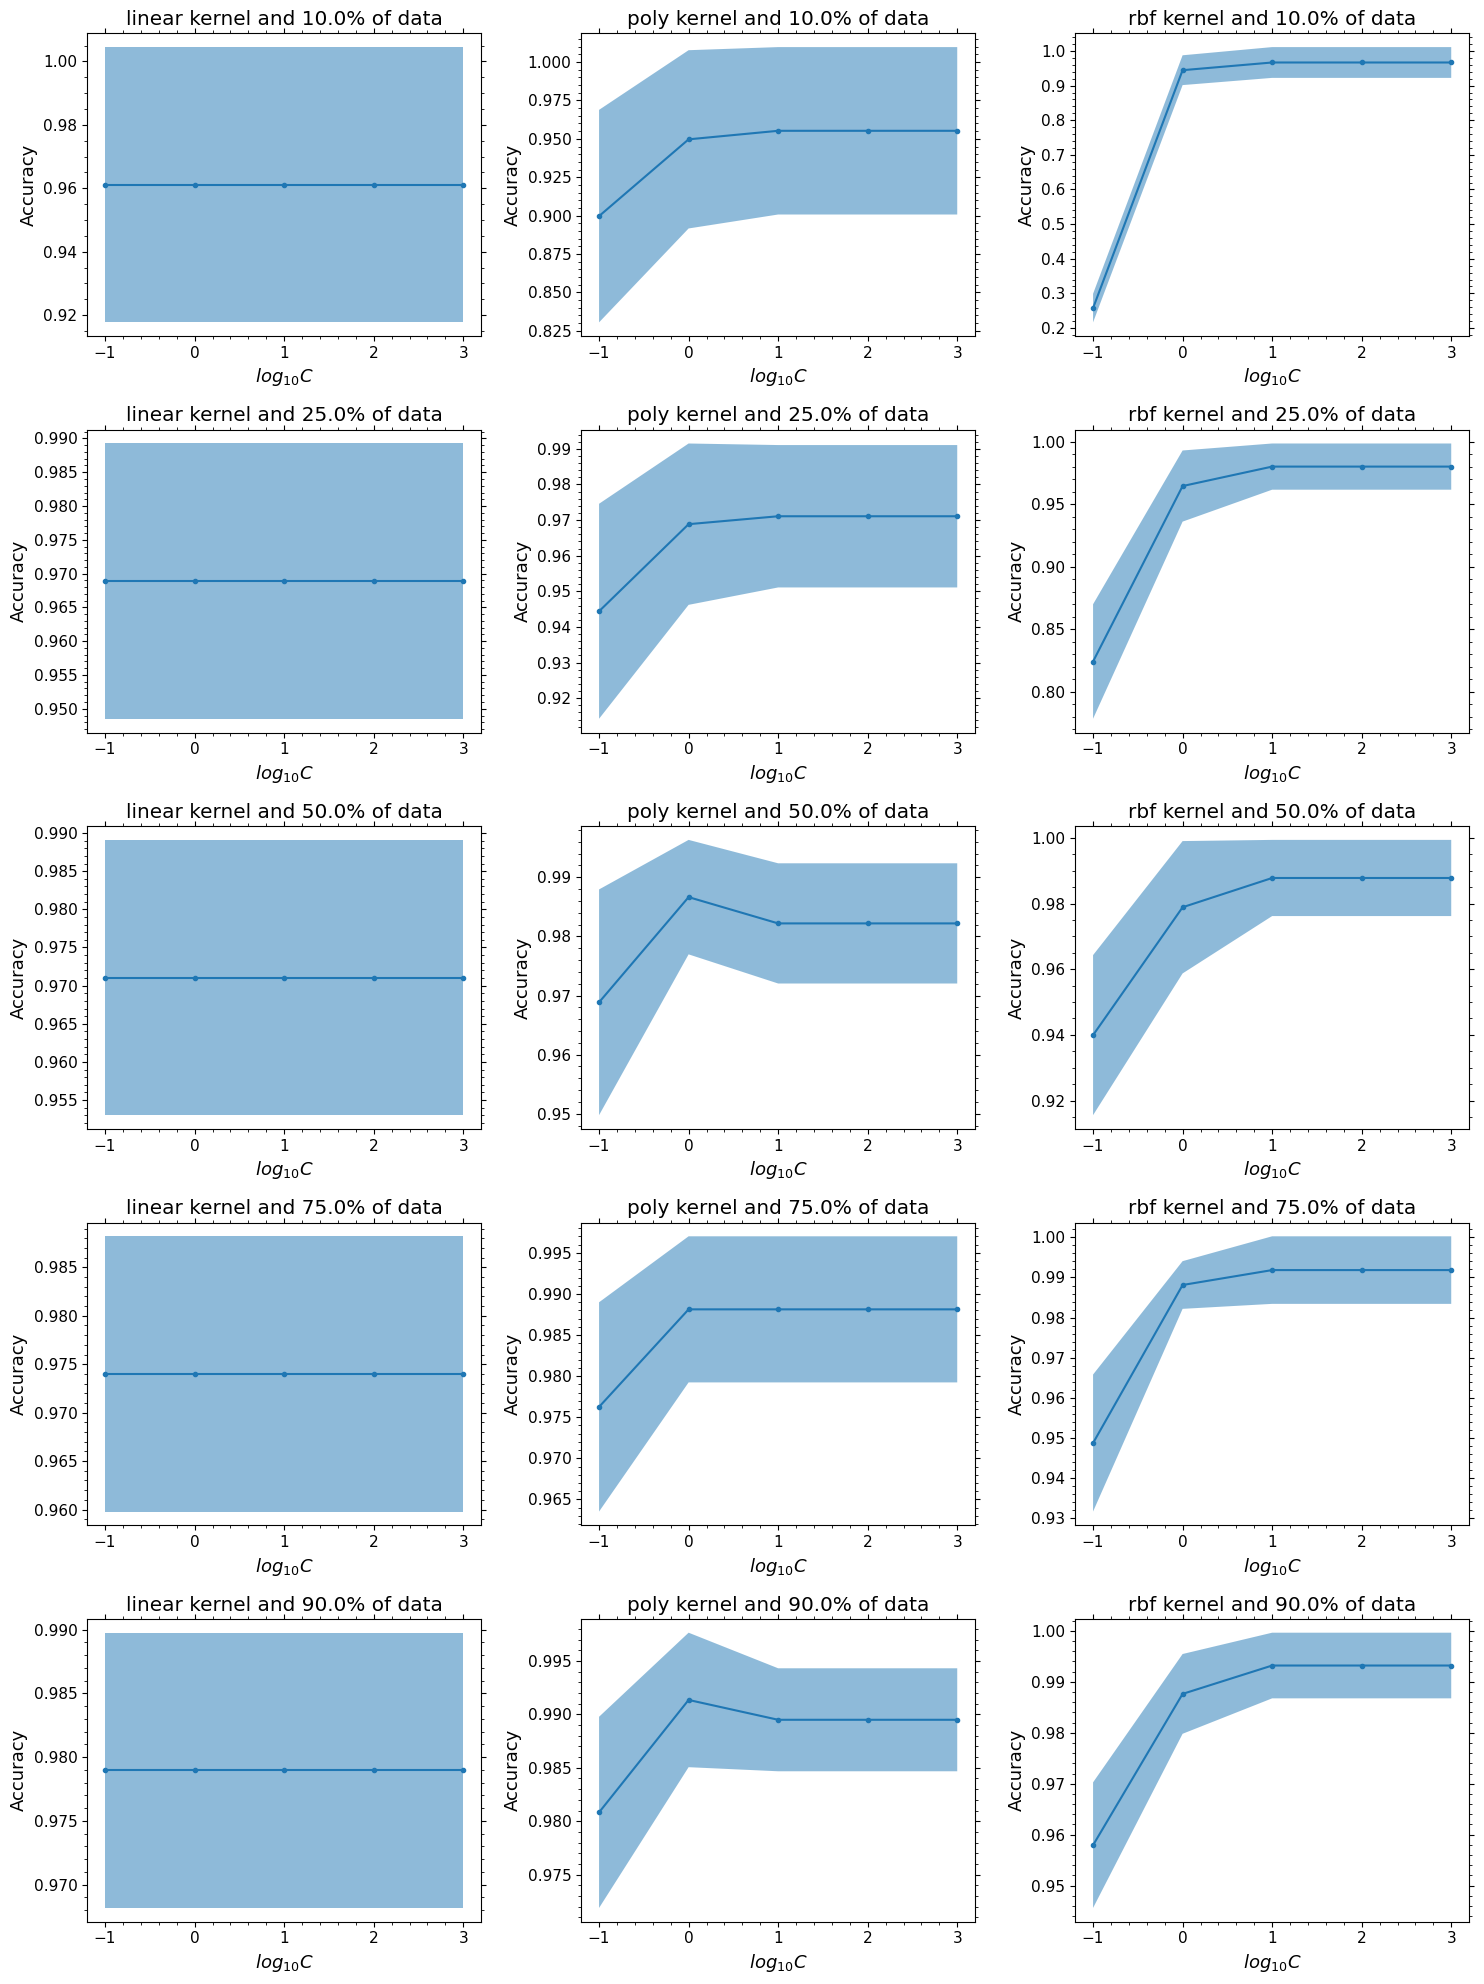

In [62]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

for idx1, size in enumerate([.10, .25, .50, .75, .90]):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=size)
    svm_cv = GridSearchCV(SVC(C=10, kernel="rbf"), param_grid={"C":np.logspace(-1,3,5), "kernel":["linear", "poly", "rbf"]}, cv=10)
    svm_cv.fit(X_train, y_train)
    svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")
    svm_clf = svm_cv.best_estimator_

    for idx2, kernel in enumerate(["linear", "poly", "rbf"]):
        svm_results_bykernel = svm_results[svm_results["param_kernel"] == kernel]
        ax[idx1, idx2].plot(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"], marker=".")
        ax[idx1, idx2].fill_between(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"] - svm_results_bykernel["std_test_score"],
                        svm_results_bykernel["mean_test_score"] + svm_results_bykernel["std_test_score"], alpha=.5)
        ax[idx1, idx2].set_xlabel("$log_{10} C$")
        ax[idx1, idx2].set_ylabel("Accuracy")
        ax[idx1, idx2].set_title("{} kernel and {}% of data".format(kernel, size*100))

    print("Training data available: {}%".format(size*100))
    print(svm_results[["param_kernel", "param_C", "std_test_score"]])
    print("Best train accuracy: {:.4f} Test accuracy: {:.4f}".format(accuracy_score(y_train, svm_clf.predict(X_train)), accuracy_score(y_test, svm_clf.predict(X_test))))
    print("Best train F1-score: {:.4f} Test F1-score: {:.4f}".format(f1_score(y_train, svm_clf.predict(X_train), average="macro"), f1_score(y_test, svm_clf.predict(X_test), average="macro")))
    print("*"*10,"\n\n")

plt.show()

We see that all models become more stable as the size of the training data increases, due to the falling standard deviations of the accuracies in the cross-validation. We also see an increase in accuracy and F-score, but this appears to plateau around 50-75% of the data, with slight evidence of a decrease when we use 90% of the data to train, which may indicate overtraining at this point.

### Question 2.c.

In [63]:
g = np.random.default_rng(seed=42)

rnd_idx = g.choice(range(len(X)), 5)
outliers_X = X[rnd_idx, :] + g.multivariate_normal(np.zeros(64), 1*np.diag(np.std(X, axis=0)), 5)
outliers_y = g.choice(range(10), 5)

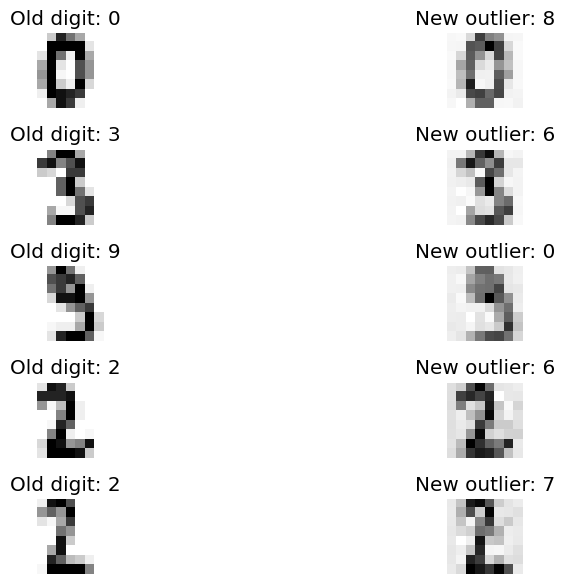

In [64]:
fig, ax = plt.subplots(5,2,figsize=(12,6))
for idx in range(5):
    ax[idx , 0].imshow(X[rnd_idx[idx]].reshape((8,8)), cmap="Greys")
    ax[idx, 0].axis("off")
    ax[idx, 0].set_title("Old digit: {}".format(y[rnd_idx[idx]]))
    ax[idx , 1].imshow(outliers_X[idx].reshape((8,8)), cmap="Greys")
    ax[idx, 1].axis("off")
    ax[idx, 1].set_title("New outlier: {}".format(outliers_y[idx]))
plt.show()

We introduce outliers in a very similar fashion as before, selecting datapoints randomly, adding random noise, and then relabelling.

In [65]:
X = np.vstack([X, outliers_X])
y = np.hstack([y, outliers_y])

/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 10.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.064788
1          poly      0.1        0.085346
2           rbf      0.1        0.089581
3        linear      1.0        0.064788
4          poly      1.0        0.058002
5           rbf      1.0        0.064788
6        linear     10.0        0.064788
7          poly     10.0        0.055556
8           rbf     10.0        0.052411
9        linear    100.0        0.064788
10         poly    100.0        0.055556
11          rbf    100.0        0.055556
12       linear   1000.0        0.064788
13         poly   1000.0        0.055556
14          rbf   1000.0        0.055556
Best train accuracy: 0.9944 Test accuracy: 0.9371
Best train F1-score: 0.9928 Test F1-score: 0.9366
********** 




/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 25.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.024845
1          poly      0.1        0.031111
2           rbf      0.1        0.033036
3        linear      1.0        0.024845
4          poly      1.0        0.022662
5           rbf      1.0        0.024444
6        linear     10.0        0.024845
7          poly     10.0        0.020488
8           rbf     10.0        0.023934
9        linear    100.0        0.024845
10         poly    100.0        0.020488
11          rbf    100.0        0.023934
12       linear   1000.0        0.024845
13         poly   1000.0        0.020488
14          rbf   1000.0        0.023934
Best train accuracy: 0.9978 Test accuracy: 0.9771
Best train F1-score: 0.9977 Test F1-score: 0.9771
********** 




/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 50.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.019895
1          poly      0.1        0.012582
2           rbf      0.1        0.023814
3        linear      1.0        0.019895
4          poly      1.0        0.011503
5           rbf      1.0        0.012933
6        linear     10.0        0.019895
7          poly     10.0        0.014366
8           rbf     10.0        0.012530
9        linear    100.0        0.019895
10         poly    100.0        0.014366
11          rbf    100.0        0.012530
12       linear   1000.0        0.019895
13         poly   1000.0        0.014366
14          rbf   1000.0        0.012530
Best train accuracy: 0.9978 Test accuracy: 0.9845
Best train F1-score: 0.9977 Test F1-score: 0.9845
********** 




/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 75.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.011358
1          poly      0.1        0.006806
2           rbf      0.1        0.014745
3        linear      1.0        0.011358
4          poly      1.0        0.007256
5           rbf      1.0        0.007982
6        linear     10.0        0.011358
7          poly     10.0        0.007238
8           rbf     10.0        0.006459
9        linear    100.0        0.011358
10         poly    100.0        0.007238
11          rbf    100.0        0.006459
12       linear   1000.0        0.011358
13         poly   1000.0        0.007238
14          rbf   1000.0        0.006459
Best train accuracy: 0.9993 Test accuracy: 0.9845
Best train F1-score: 0.9993 Test F1-score: 0.9845
********** 




/tmp/ipykernel_14573/2295643483.py:7: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")


Training data available: 90.0%
   param_kernel  param_C  std_test_score
0        linear      0.1        0.007304
1          poly      0.1        0.009741
2           rbf      0.1        0.016762
3        linear      1.0        0.007304
4          poly      1.0        0.008732
5           rbf      1.0        0.007203
6        linear     10.0        0.007304
7          poly     10.0        0.005828
8           rbf     10.0        0.006651
9        linear    100.0        0.007304
10         poly    100.0        0.005828
11          rbf    100.0        0.006651
12       linear   1000.0        0.007304
13         poly   1000.0        0.005828
14          rbf   1000.0        0.006651
Best train accuracy: 0.9994 Test accuracy: 0.9724
Best train F1-score: 0.9994 Test F1-score: 0.9726
********** 




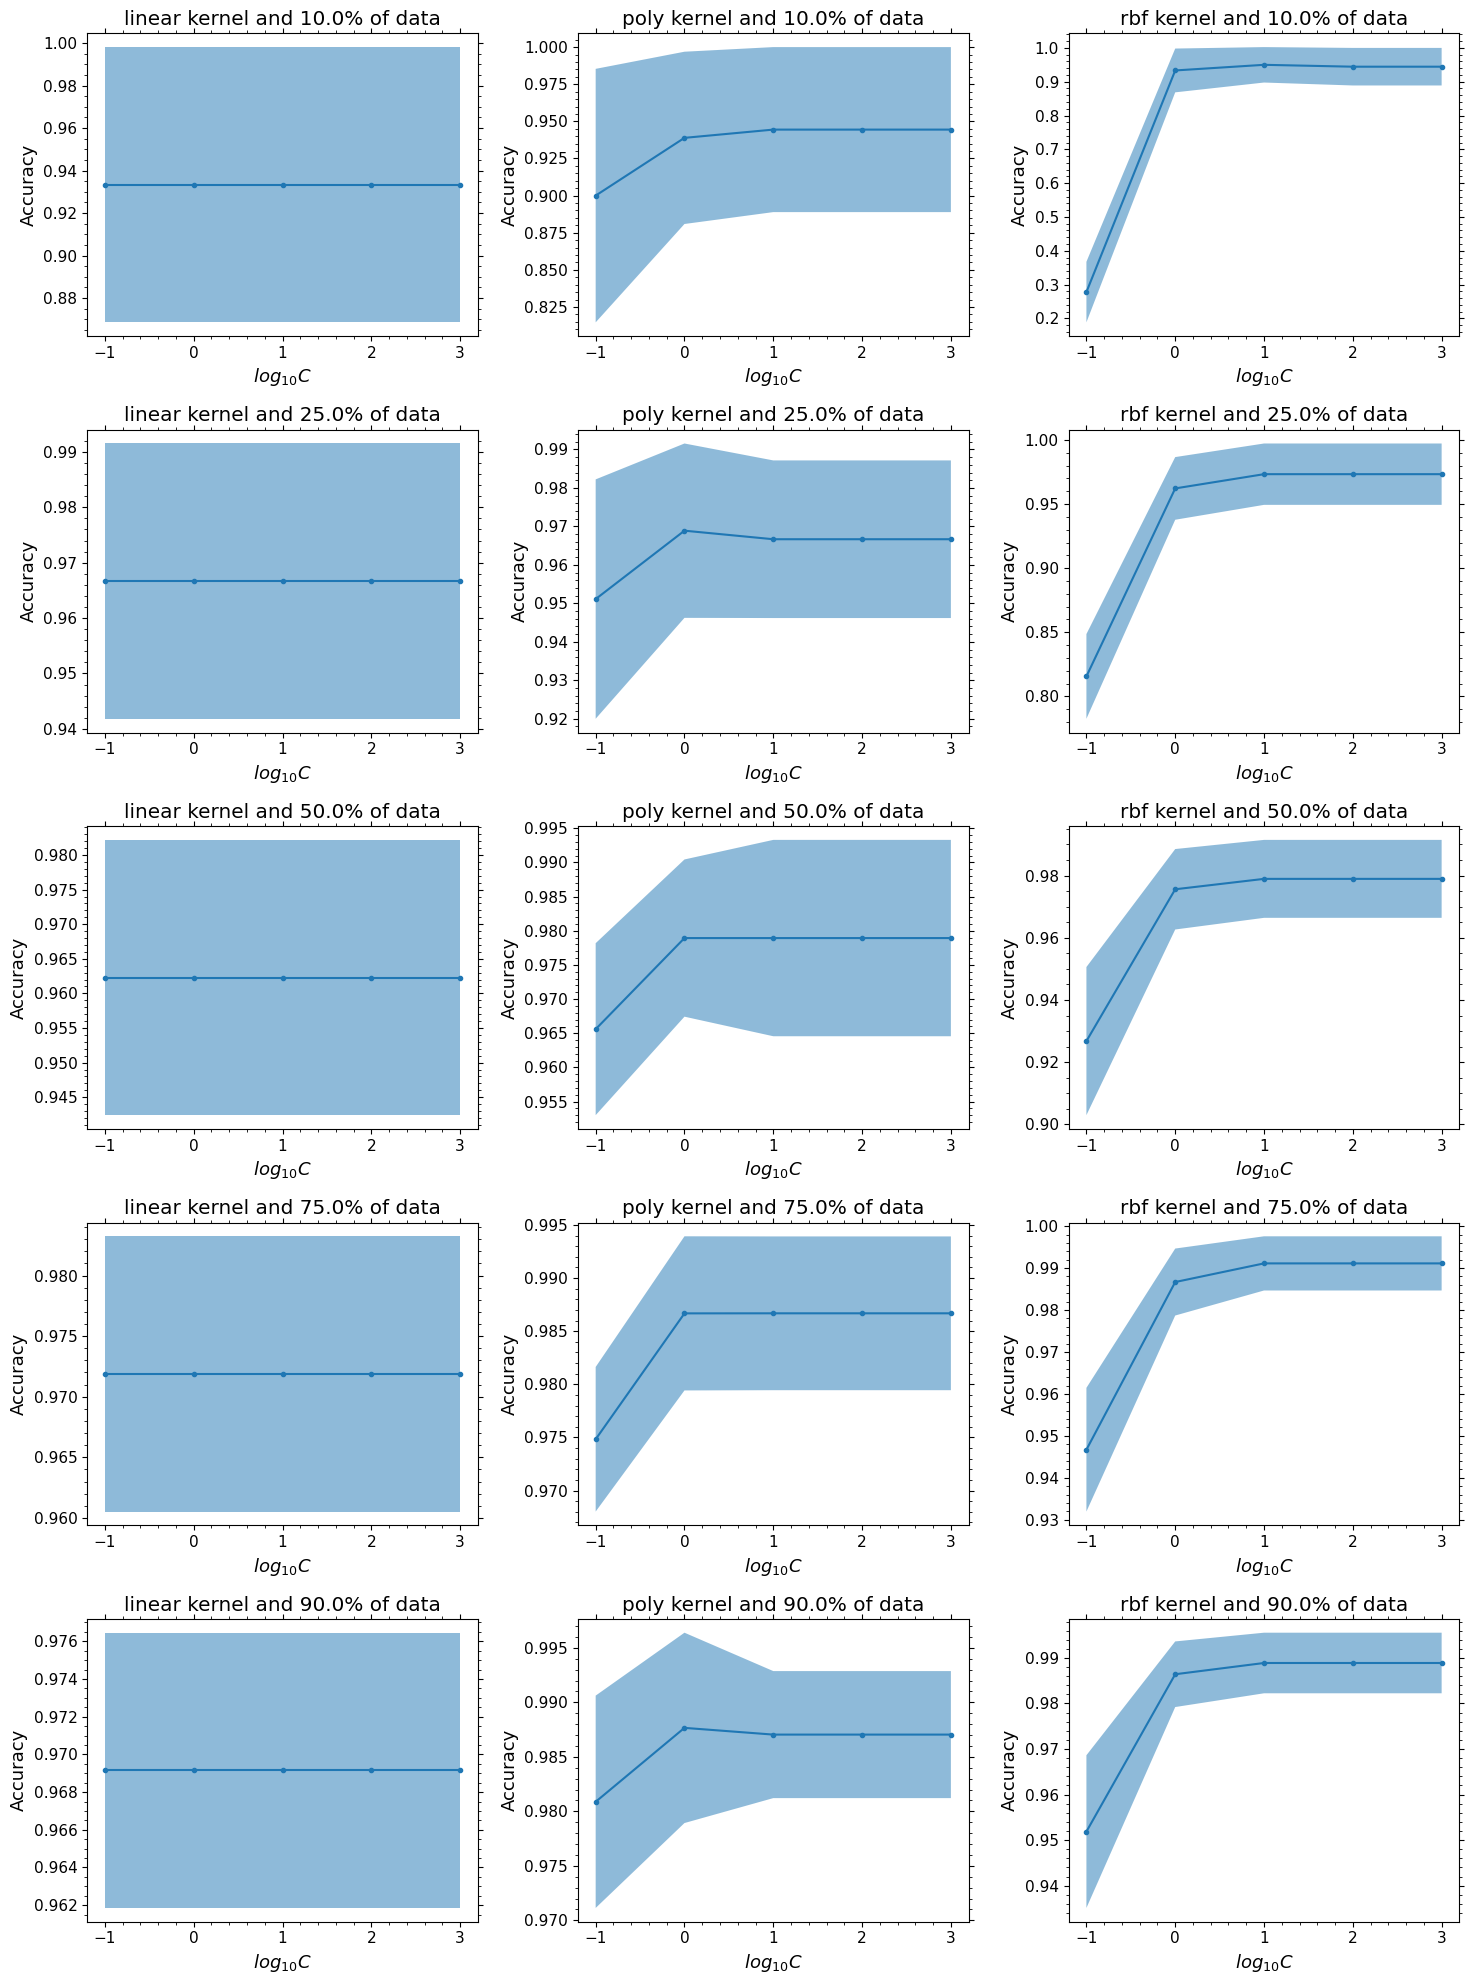

In [66]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

for idx1, size in enumerate([.10, .25, .50, .75, .90]):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=size)
    svm_cv = GridSearchCV(SVC(C=10, kernel="rbf"), param_grid={"C":np.logspace(-1,3,5), "kernel":["linear", "poly", "rbf"]}, cv=10)
    svm_cv.fit(X_train, y_train)
    svm_results = pd.DataFrame(svm_cv.cv_results_, dtype="float64")
    svm_clf = svm_cv.best_estimator_

    for idx2, kernel in enumerate(["linear", "poly", "rbf"]):
        svm_results_bykernel = svm_results[svm_results["param_kernel"] == kernel]
        ax[idx1, idx2].plot(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"], marker=".")
        ax[idx1, idx2].fill_between(np.log10(svm_results_bykernel["param_C"]), svm_results_bykernel["mean_test_score"] - svm_results_bykernel["std_test_score"],
                        svm_results_bykernel["mean_test_score"] + svm_results_bykernel["std_test_score"], alpha=.5)
        ax[idx1, idx2].set_xlabel("$log_{10} C$")
        ax[idx1, idx2].set_ylabel("Accuracy")
        ax[idx1, idx2].set_title("{} kernel and {}% of data".format(kernel, size*100))

    print("Training data available: {}%".format(size*100))
    print(svm_results[["param_kernel", "param_C", "std_test_score"]])
    print("Best train accuracy: {:.4f} Test accuracy: {:.4f}".format(accuracy_score(y_train, svm_clf.predict(X_train)), accuracy_score(y_test, svm_clf.predict(X_test))))
    print("Best train F1-score: {:.4f} Test F1-score: {:.4f}".format(f1_score(y_train, svm_clf.predict(X_train), average="macro"), f1_score(y_test, svm_clf.predict(X_test), average="macro")))
    print("*"*10,"\n\n")

plt.show()

In the case of added outliers, it seems that there is a similar trend in the stability of the models, which increases for all hyperparamter values as the training data size increases. However, it appears that the boundary for overtraining occurs at a smaller proportion of the data and is more pronounced; the test accuracy and f-score for the 90% training data cross-validation is now more significantly lower than for 75%. This reflects the fact that we have increased the irreducible 'noise' in the data, which increases the propensity to overtrain, i.e. at 90% the model is incorporating the outliers and thus performing worse in testing.